<a href="https://colab.research.google.com/github/Rakhayeva/Data-Science-Projects-in-English/blob/main/segmentation_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Description

**Project Description:**

The company "One Click" has encountered a problem of declining purchasing activity among its loyal customers. The main goal of the project is to develop a model that will predict the probability of a decrease in a client's purchasing activity, as well as to identify client segments for developing personalized offers that promote increased activity.

**Project Goal:**

- Build a model that predicts the probability of a decrease in purchasing activity of customers.

- Analyze the identified customer segments and propose strategies to increase their activity based on model data and profitability indicators.

**Research Progress:**

1. [**Data Loading**](#Loading)

- Importing data from the provided tables.

2. [**Data Preprocessing and Exploration**](#Preprocessing)

- Transforming data for further analysis (Translating columns and values to English).
- Data cleaning and processing (eliminating missing values, anomalies, adjusting formats).
- Checking data compliance with the description.

3. [**Exploratory Data Analysis**](#Analysis)

- Analyzing customer behavior, revenue, time on site, and other features.

- Selecting customers with activity of at least three months.

4. [**Data Merging**](#Merging)

- Creating a final table by merging data from various sources.

- Transforming revenue and time on site features into separate columns for each period.

5. [**Correlation Analysis**](#Correlation)

- Analysis of multicollinearity of quantitative features.

- Elimination of redundant features if necessary.

6. [**Model Building using Pipelines**](#Pipelines)

- Preparing data via ColumnTransformer to handle categorical and quantitative features.

- Training four models (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC).

- Tuning hyperparameters using a suitable metric.

- Selecting the best model.

7. [**Feature Importance Analysis**](#Importance)

- Assessing feature importance using the SHAP method.

- Identifying the most and least significant features for the model.

8. [**Customer Segmentation**](#Segmentation)

- Identifying customer groups based on the model and profitability indicators.

- Analyzing the selected group and developing recommendations to increase its activity.

9. [**General Conclusion**](#Conclusion)

- Description of the work performed, the best models, and proposals for the identified customer segments.

## Data Description

**For the dataset `market_file.csv`:**

- `id`: Customer number in the corporate database.

- `buyer_activity`: Calculated class of purchasing activity (target variable): "decreased" or "previous level".

- `service_type`: Service level, e.g., "premium" and "standard".

- `marketing_consent`: Information on whether additional product offers can be sent to the customer. Consent is given by the customer.

- `marketing_activity_6m`: Average monthly value of the company's marketing communications directed at the customer over the last 6 months. This value shows the number of mailings, calls, ad impressions, etc.

- `marketing_activity_current_month`: Number of marketing communications in the current month.

- `duration_days`: Value showing how many days have passed since the customer registered on the site.

- `promo_purchases_share`: Average monthly share of purchases on promotion out of the total number of purchases over the last 6 months.

- `popular_category`: The customer's most popular product category over the last 6 months.

- `avg_categories_per_visit`: Shows how many categories on average the customer viewed per visit during the last month.

- `unpaid_products_quarter`: Total number of unpaid items in the cart over the last 3 months.

- `service_errors`: Number of failures that affected the customer during the site visit.

- `pages_per_visit`: Average number of pages viewed by the customer per site visit over the last 3 months.


**For the dataset `market_money.csv`:**

- `id`: Customer number in the corporate database.

- `period`: Name of the period during which revenue was recorded. For example, 'current_month' or 'previous_month'.

- `revenue`: Revenue amount for the period.


**For the dataset `market_time.csv`:**

- `id`: Customer number in the corporate database.

- `period`: Name of the period during which total time was recorded.

- `minutes`: Value of time spent on the site, in minutes.


**For the dataset `money.csv`:**

- `id`: Customer number in the corporate database.

- `profit`: Profit value.

## <a name='Loading'></a> Data Loading

Importing Libraries and Modules:

In [1]:
!pip install -q imblearn
!pip install -q phik
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import optuna
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cycler import cycler
import seaborn as sns

import numpy as np
from scipy import stats as st
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import make_scorer

from optuna import distributions
from optuna.integration import OptunaSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.inspection import permutation_importance
import shap

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Constants:

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Functions

In [4]:
def detailed_df_analysis(df, df_name):
    """
    Function to get extended primary information about the data table.
    """
    print(f"--- Main information about dataset: {df_name} ---")
    df.info()
    print("\n")

    print(f"--- First rows of the dataset: {df_name} ---")
    display(df.head())
    print("\n")

    # Missing values
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    print("Missing values:")
    print(pd.DataFrame({'count': missing_values, 'percentage': missing_percent}), "\n")

    # Number of duplicate rows
    duplicates = df.duplicated().sum()
    print(f"Number of duplicates: {duplicates}\n")

    # Information on categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("Information about categorical features:")
        for col in categorical_cols:
            unique_count = df[col].nunique()
            unique_values = df[col].unique()
            print(f"{col} => {unique_count} unique values")
            for value in unique_values:
                print(f"  - {value}")
            print()
    else:
        print("No categorical features present.\n")

In [5]:
def plot_histograms_boxplots(df):
    """
    Plots histograms and boxplots for each numerical column in the DataFrame.
    """
    # Select numerical columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    # If no numerical columns, print message and return
    if len(numeric_cols) == 0:
        print("No numerical columns.")
        return

    # Number of rows and columns in the plot grid
    num_cols = 2  # Two plots (histogram and boxplot) per row
    num_rows = len(numeric_cols)

    # Create figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Simplify axis access

    # Plotting
    for i, col in enumerate(numeric_cols):
        # Histogram
        sns.histplot(df[col], bins=15, kde=False, ax=axes[2 * i])
        axes[2 * i].set_title(f'Histogram of {col}')
        axes[2 * i].set_xlabel(col)
        axes[2 * i].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[2 * i + 1])
        axes[2 * i + 1].set_title(f'Box Plot of {col}')
        axes[2 * i + 1].set_xlabel(col)

    # Remove extra empty axes if any
    for ax in axes[len(numeric_cols) * 2:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

In [6]:
def plot_countplots(df):
    """
    Plots countplots for each categorical factor in the DataFrame.
    """
    # Select categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Check for categorical columns
    if len(categorical_cols) == 0:
        print("No categorical columns.")
        return

    # Plot grid setup
    num_cols = 2  # Number of plots per row
    num_rows = (len(categorical_cols) + num_cols - 1) // num_cols  # Round up

    # Create figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))
    axes = axes.flatten()  # Simplify axis access

    # Plot countplots for each categorical column
    for i, col in enumerate(categorical_cols):
        sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=axes[i])
        axes[i].set_title(f'Plot for {col}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)

    # Remove extra axes
    for ax in axes[len(categorical_cols):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

Loading Data:

In [7]:
# Reading the CSV file with game sales data
market_file = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/market_file.csv')
market_money = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/market_money.csv')
market_time = pd.read_csv('//content/drive/MyDrive/Yandex_Practicum/datasets for DS/market_time.csv')
money = pd.read_csv('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/money.csv', sep=";", decimal=",")

## <a name='Preprocessing'></a> Data Preprocessing and Exploration

Translating into English column names and their values:

In [8]:
# Rename columns to English (snake_case)
market_file = market_file.rename(columns={
    'Покупательская активность': 'buyer_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'marketing_consent',
    'Маркет_актив_6_мес': 'marketing_activity_6m',
    'Маркет_актив_тек_мес': 'marketing_activity_current_month',
    'Длительность': 'duration_days',
    'Акционные_покупки': 'promo_purchases_share',
    'Популярная_категория': 'popular_category',
    'Средний_просмотр_категорий_за_визит': 'avg_categories_per_visit',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_products_quarter',
    'Ошибка_сервиса': 'service_errors',
    'Страниц_за_визит': 'pages_per_visit'
})

# Fix typo and translate values
market_file.loc[market_file['service_type'] == 'стандартт', 'service_type'] = 'standard'
market_file['service_type'] = market_file['service_type'].replace({'премиум': 'premium', 'стандарт': 'standard'})
market_file['buyer_activity'] = market_file['buyer_activity'].replace({'Снизилась': 'Decreased', 'Прежний уровень': 'Stable'})
market_file['marketing_consent'] = market_file['marketing_consent'].replace({'да': 'yes', 'нет': 'no'})

category_map = {
    'Товары для детей': 'Baby Products',
    'Домашний текстиль': 'Home Textiles',
    'Косметика и аксесуары': 'Cosmetics and Accessories',
    'Техника для красоты и здоровья': 'Beauty and Health Appliances',
    'Кухонная посуда': 'Kitchenware',
    'Мелкая бытовая техника и электроника': 'Small Electronics'
}
market_file['popular_category'] = market_file['popular_category'].replace(category_map)

# 2. Processing market_money
market_money = market_money.rename(columns={'Период': 'period', 'Выручка': 'revenue'})
period_map = {
    'текущий_месяц': 'current_month',
    'предыдущий_месяц': 'previous_month',
    'препредыдущий_месяц': 'pre_previous_month'
}
market_money['period'] = market_money['period'].replace(period_map)

# 3. Processing market_time
market_time = market_time.rename(columns={'Период': 'period', 'минут': 'minutes'})
time_period_map = {
    'текущий_месяц': 'current_month',
    'предыдцщий_месяц': 'previous_month',
    'предыдущий_месяц': 'previous_month'
}
market_time['period'] = market_time['period'].replace(time_period_map)

# 4. Processing money
money = money.rename(columns={'Прибыль': 'profit'})

In [9]:
detailed_df_analysis(market_file, 'market_file')

--- Main information about dataset: market_file ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1300 non-null   int64  
 1   buyer_activity                    1300 non-null   object 
 2   service_type                      1300 non-null   object 
 3   marketing_consent                 1300 non-null   object 
 4   marketing_activity_6m             1300 non-null   float64
 5   marketing_activity_current_month  1300 non-null   int64  
 6   duration_days                     1300 non-null   int64  
 7   promo_purchases_share             1300 non-null   float64
 8   popular_category                  1300 non-null   object 
 9   avg_categories_per_visit          1300 non-null   int64  
 10  unpaid_products_quarter           1300 non-null   int64  
 11  service_errors   

id buyer_activity service_type marketing_consent  \
0  215348      Decreased      premium               yes   
1  215349      Decreased      premium               yes   
2  215350      Decreased     standard                no   
3  215351      Decreased     standard               yes   
4  215352      Decreased     standard                no   

   marketing_activity_6m  marketing_activity_current_month  duration_days  \
0                    3.4                                 5            121   
1                    4.4                                 4            819   
2                    4.9                                 3            539   
3                    3.2                                 5            896   
4                    5.1                                 3           1064   

   promo_purchases_share popular_category  avg_categories_per_visit  \
0                   0.00    Baby Products                         6   
1                   0.75    Baby Products                         4   
2                   0.14    Home Textiles                         5   
3                   0.99    Baby Products                         5   
4                   0.94    Baby Products                         3   

   unpaid_products_quarter  service_errors  pages_per_visit  
0                        2               1                5  
1                        4               2                5  
2                        2               1                5  
3                        0               6                4  
4                        2               3                2



Missing values:
                                  count  percentage
id                                    0         0.0
buyer_activity                        0         0.0
service_type                          0         0.0
marketing_consent                     0         0.0
marketing_activity_6m                 0         0.0
marketing_activity_current_month      0         0.0
duration_days                         0         0.0
promo_purchases_share                 0         0.0
popular_category                      0         0.0
avg_categories_per_visit              0         0.0
unpaid_products_quarter               0         0.0
service_errors                        0         0.0
pages_per_visit                       0         0.0 

Number of duplicates: 0

Information about categorical features:
buyer_activity => 2 unique values
  - Decreased
  - Stable

service_type => 2 unique values
  - premium
  - standard

marketing_consent => 2 unique values
  - yes
  - no

popular_category

Everythink is ok.

In [10]:
detailed_df_analysis(market_money, 'market_money')

--- Main information about dataset: market_money ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


--- First rows of the dataset: market_money ---


id              period  revenue
0  215348  pre_previous_month      0.0
1  215348       current_month   3293.1
2  215348      previous_month      0.0
3  215349  pre_previous_month   4472.0
4  215349       current_month   4971.6



Missing values:
         count  percentage
id           0         0.0
period       0         0.0
revenue      0         0.0 

Number of duplicates: 0

Information about categorical features:
period => 3 unique values
  - pre_previous_month
  - current_month
  - previous_month



Everything is ok.

In [11]:
detailed_df_analysis(market_time, 'market_time')

--- Main information about dataset: market_time ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


--- First rows of the dataset: market_time ---


id          period  minutes
0  215348   current_month       14
1  215348  previous_month       13
2  215349   current_month       10
3  215349  previous_month       12
4  215350   current_month       13



Missing values:
         count  percentage
id           0         0.0
period       0         0.0
minutes      0         0.0 

Number of duplicates: 0

Information about categorical features:
period => 2 unique values
  - current_month
  - previous_month



In [12]:
detailed_df_analysis(money, 'money')

--- Main information about dataset: money ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


--- First rows of the dataset: money ---


id  profit
0  215348    0.98
1  215349    4.16
2  215350    3.13
3  215351    4.87
4  215352    4.21



Missing values:
        count  percentage
id          0         0.0
profit      0         0.0 

Number of duplicates: 0

No categorical features present.



All datasets look good.

**Conclusion:**

- All datasets have been successfully loaded and column names/values translated to English.

- No missing values or duplicates were found in the provided tables.

- Data types correspond to the content.

- Typographical errors in the raw data were handled during the translation/renaming phase.

## <a name='Analysis'></a> Exploratory Data Analysis

- We will study the statistics of all tables and outliers using boxplots.

- We will select clients with purchasing activity of at least three months.

In [13]:
market_file = market_file.set_index('id')
market_money = market_money.set_index('id')
market_time = market_time.set_index('id')
money = money.set_index('id')

### market_file

In [14]:
# View summary statistical information about numerical data
market_file.describe()

marketing_activity_6m  marketing_activity_current_month  duration_days  \
count            1300.000000                       1300.000000    1300.000000   
mean                4.253769                          4.011538     601.898462   
std                 1.014814                          0.696868     249.856289   
min                 0.900000                          3.000000     110.000000   
25%                 3.700000                          4.000000     405.500000   
50%                 4.200000                          4.000000     606.000000   
75%                 4.900000                          4.000000     806.000000   
max                 6.600000                          5.000000    1079.000000   

       promo_purchases_share  avg_categories_per_visit  \
count            1300.000000                1300.00000   
mean                0.319808                   3.27000   
std                 0.249843                   1.35535   
min                 0.000000                   1.00000   
25%                 0.170000                   2.00000   
50%                 0.240000                   3.00000   
75%                 0.300000                   4.00000   
max                 0.990000                   6.00000   

       unpaid_products_quarter  service_errors  pages_per_visit  
count              1300.000000     1300.000000      1300.000000  
mean                  2.840000        4.185385         8.176923  
std                   1.971451        1.955298         3.978126  
min                   0.000000        0.000000         1.000000  
25%                   1.000000        3.000000         5.000000  
50%                   3.000000        4.000000         8.000000  
75%                   4.000000        6.000000        11.000000  
max                  10.000000        9.000000        20.000000

In [15]:
market_file.describe(include=['object'])

buyer_activity service_type marketing_consent popular_category
count            1300         1300              1300             1300
unique              2            2                 2                6
top            Stable     standard               yes    Baby Products
freq              802          924               962              330

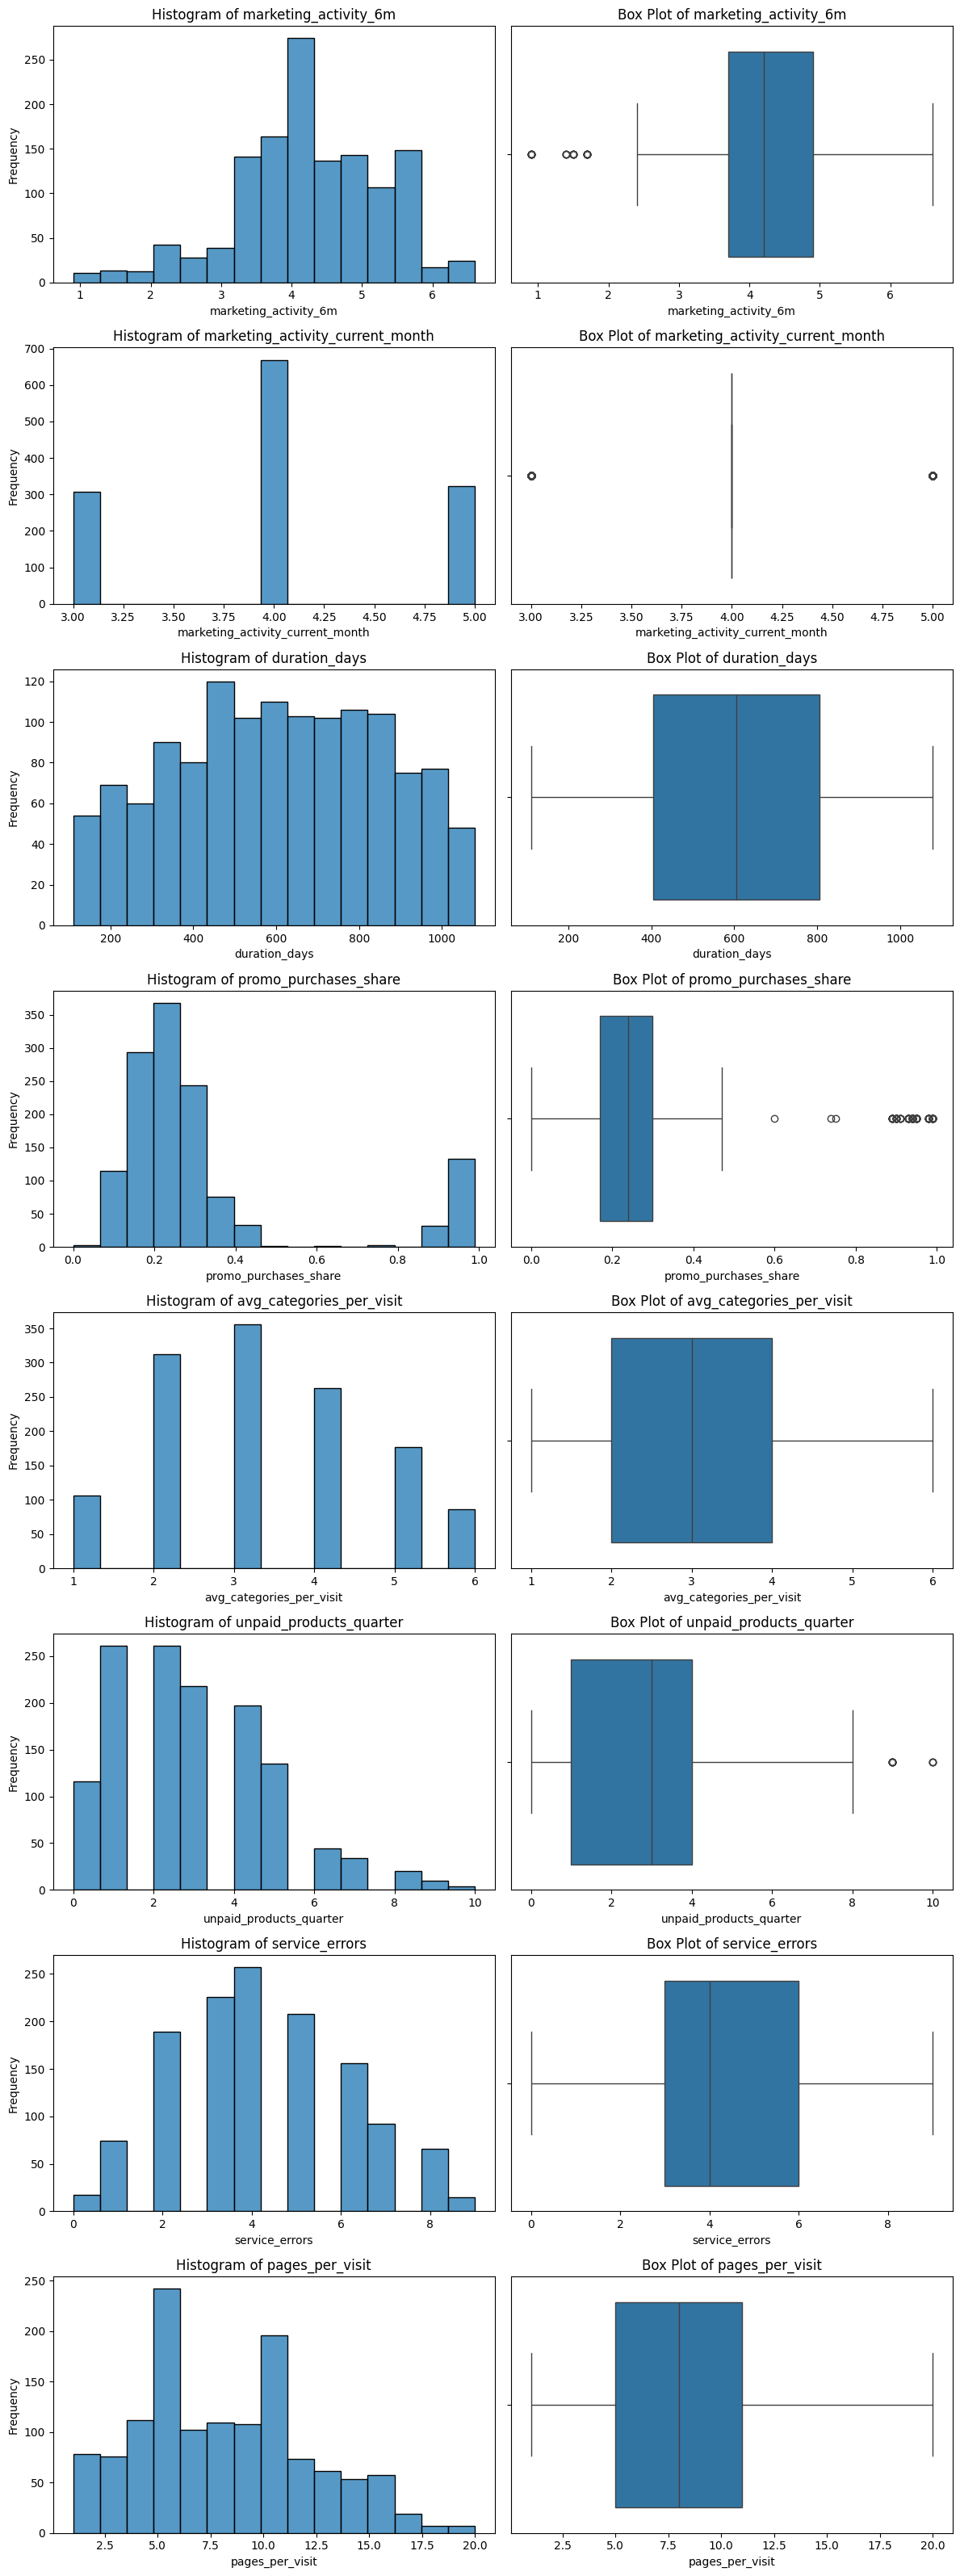

In [16]:
plot_histograms_boxplots(market_file)

- In the parameters `marketing_activity_6m`, `promo_purchases_share` and `unpaid_products_quarter` outliers are present.

- From the plot for the `marketing_activity_6m` parameter, we see that a certain number of values clearly fall outside the typical range. We will convert this quantitative feature into a categorical one:

   - `marketing_activity_6m_categorical`: will have values low (less than 2), medium (2 to 6), and high (above 6).

In [17]:
# Copy data to a new column
market_file['marketing_activity_6m_categorical'] = market_file['marketing_activity_6m'].apply(
lambda x: 'low' if x < 2 else 'medium' if x <= 6 else 'high'
)

# Delete the old column
market_file.drop(columns='marketing_activity_6m', inplace=True)

# Check
market_file['marketing_activity_6m_categorical'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [18]:
market_file['marketing_activity_current_month'].unique()

array([5, 4, 3])

Let's transform it into a qualitative feature.

In [19]:
# Copy data to a new column
market_file['marketing_activity_current_month_categorical'] = market_file['marketing_activity_current_month'].apply(
lambda x : 'low' if x < 3.5 else 'medium' if x <= 4.5 else 'high'
)

# Delete the old column
market_file.drop(columns='marketing_activity_current_month', inplace=True)

# Check
market_file['marketing_activity_current_month_categorical'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [20]:
market_file['promo_purchases_share'].unique()

array([0.  , 0.75, 0.14, 0.99, 0.94, 0.26, 0.23, 0.17, 0.13, 0.35, 0.74,
       0.29, 0.98, 0.95, 0.22, 0.4 , 0.24, 0.21, 0.39, 0.9 , 0.89, 0.27,
       0.33, 0.34, 0.32, 0.93, 0.3 , 0.28, 0.31, 0.25, 0.36, 0.16, 0.11,
       0.2 , 0.18, 0.15, 0.6 , 0.12, 0.19, 0.44, 0.47, 0.91])

For the `promo_purchases_share` parameter, we can define a categorical feature with a split around 0.7 (> = high, < = low).

In [21]:
# Copy data to a new column
market_file['promo_purchases_share_categorical'] = market_file['promo_purchases_share'].apply(
    lambda x : 'low' if x < 0.7 else 'high'
)

# Delete the old column
market_file.drop(columns='promo_purchases_share', inplace=True)

# Check
market_file['promo_purchases_share_categorical'].unique()

array(['low', 'high'], dtype=object)

Let's make `unpaid_products_quarter` categorical by dividing the values ​​into low (less than 1), medium (from 1 to 5), and high (above 5).

In [22]:
# Copy data to a new column
market_file['unpaid_products_quarter_categorical'] = market_file['unpaid_products_quarter'].apply(
    lambda x : 'low' if x < 1 else 'medium' if x <= 5 else 'high'
)

# Delete the old column
market_file.drop(columns='unpaid_products_quarter', inplace=True)

# Check
market_file['unpaid_products_quarter_categorical'].unique()

array(['medium', 'low', 'high'], dtype=object)

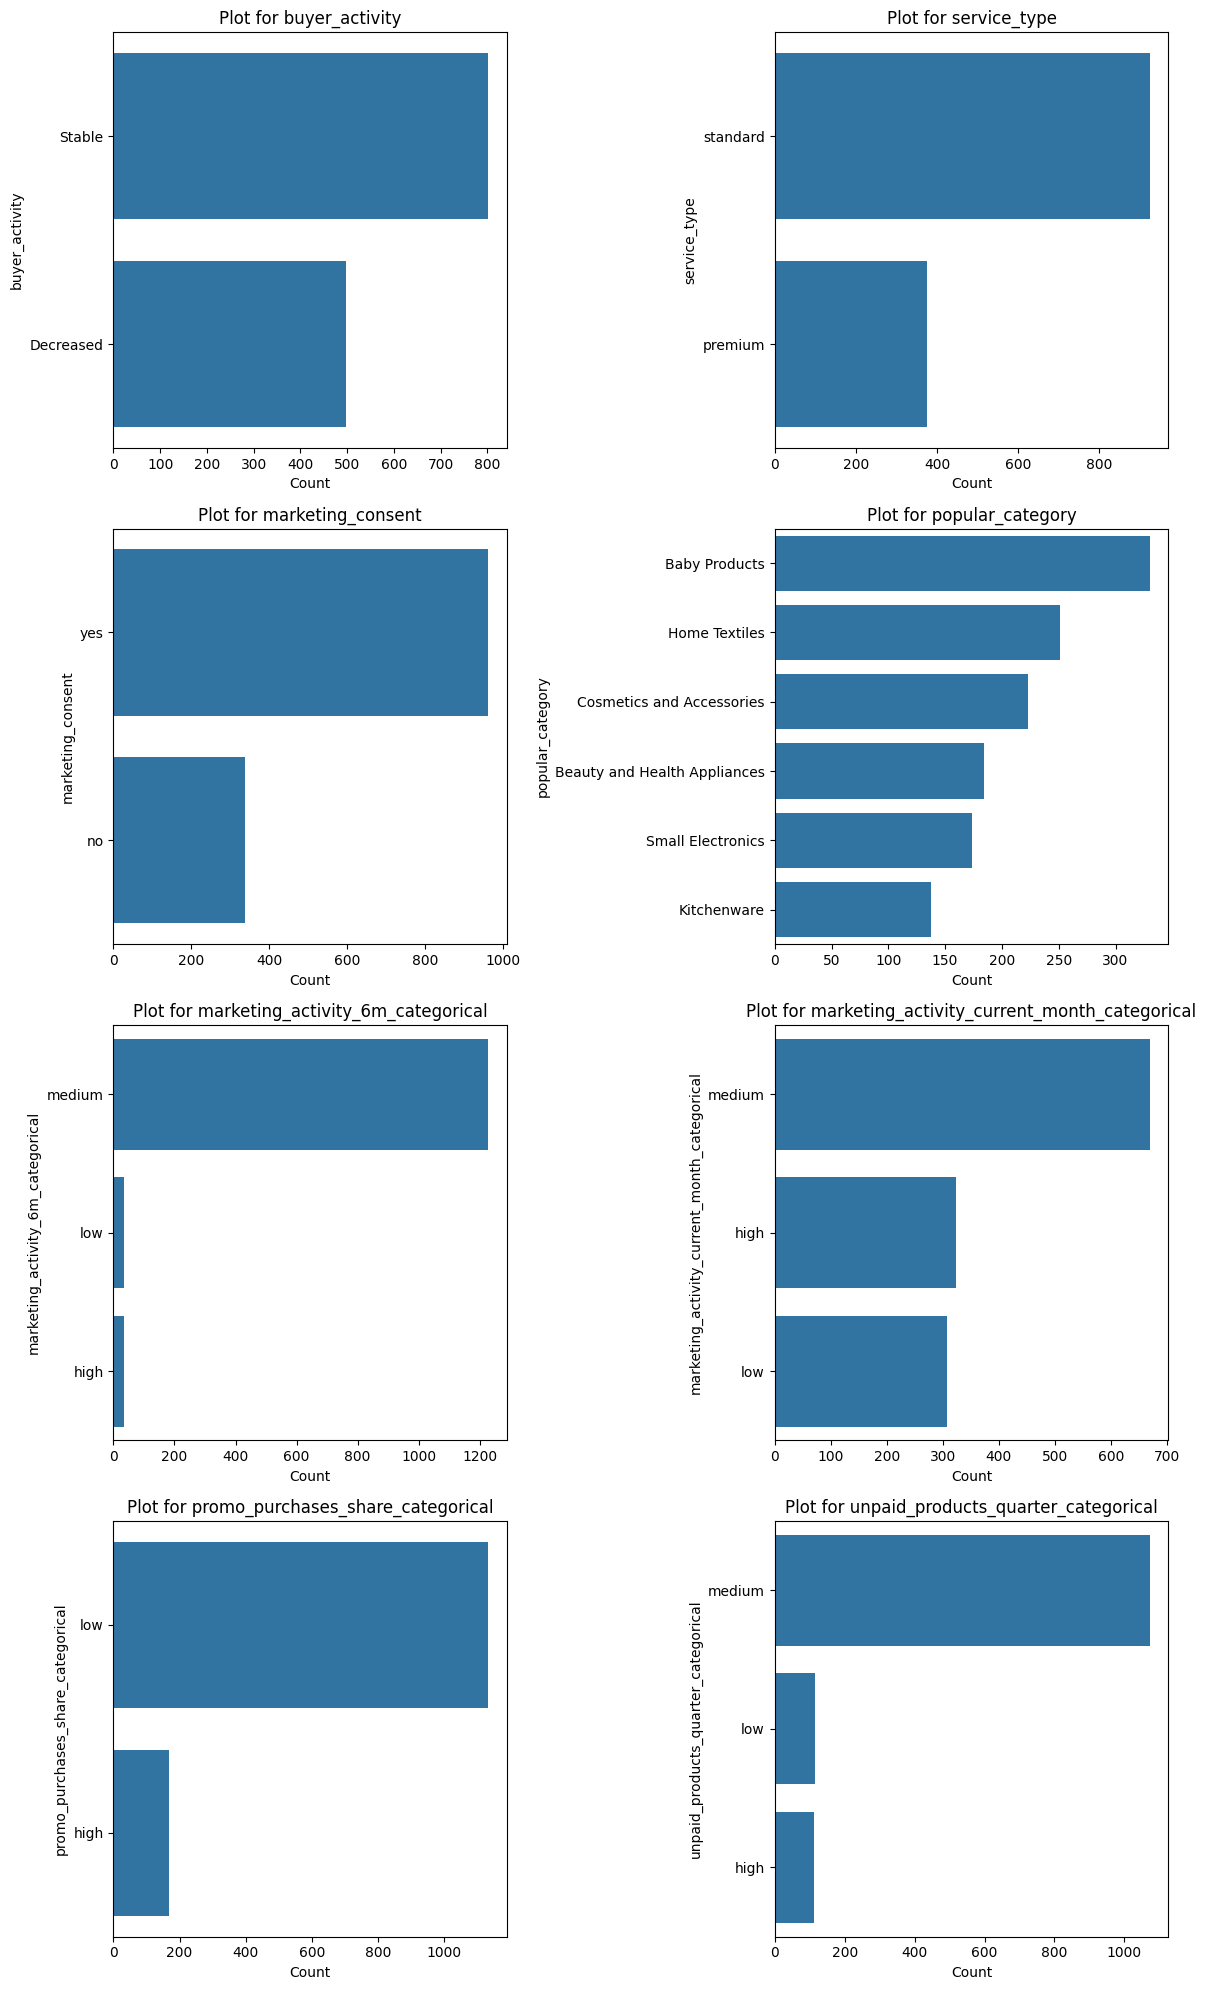

In [23]:
# # Let's study the distribution of categorical parameters of market_file
plot_countplots(market_file)

There is an imbalance in values ​​in the parameters:
- `service_type`
- `marketing_consent`
- `buyer_activity`
- `promo_purchases_share_categorical`

### market_money

In [24]:
# View summary statistics for numerical and categorical data
market_money.describe()

revenue
count    3900.000000
mean     5025.696051
std      1777.704104
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max    106862.200000

There is clearly an outlier in the data, judging by the difference between the maximum value and 75% of the data

In [25]:
market_money.describe(include=['object'])

period
count                 3900
unique                   3
top     pre_previous_month
freq                  1300

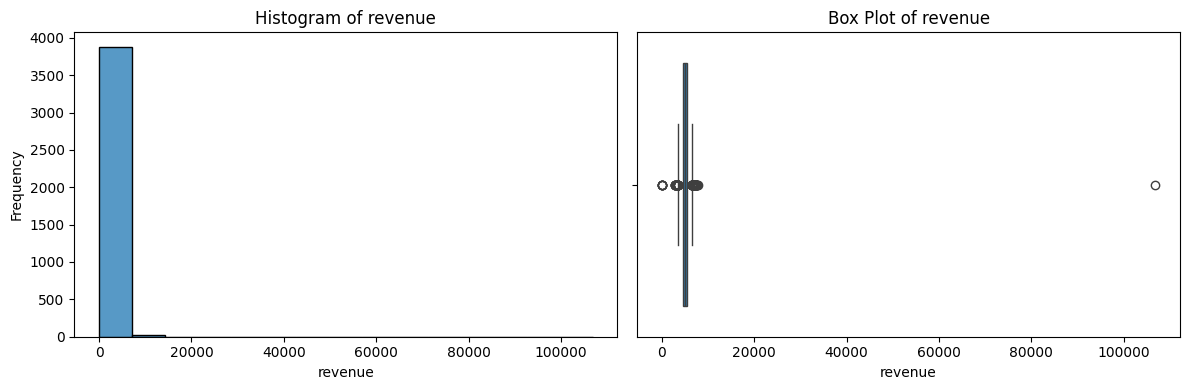

In [26]:
# Display charts for market_money
plot_histograms_boxplots(market_money)

The assumption was confirmed and the graph was flattened due to the outlier. It needs to be removed.

In [27]:
# Sort the parent data in descending order and display the first five values
market_money.sort_values(by='revenue', ascending=False).head()

period   revenue
id                             
215380  current_month  106862.2
215493  current_month    7799.4
215435  current_month    7605.3
215841  current_month    7557.0
216144  current_month    7547.8

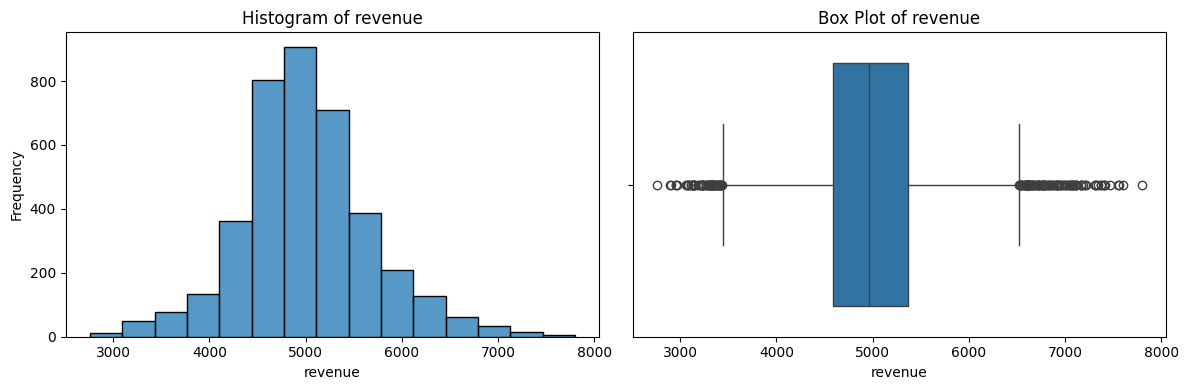

In [28]:
# Exclude the highest and zero parameter values ​​
market_money = market_money[market_money['revenue'] != 106862.2]
market_money = market_money[market_money['revenue'] != 0]

# Re-render the graphs
plot_histograms_boxplots(market_money)

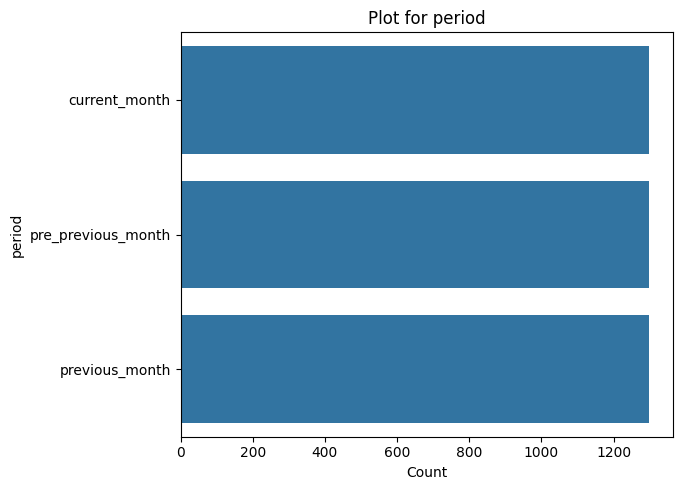

In [29]:
# Let's study the distribution of categorical features
plot_countplots(market_money)

### market_time

In [30]:
# View summary statistics for numerical and categorical data
market_time.describe()

minutes
count  2600.000000
mean     13.336154
std       4.080198
min       4.000000
25%      10.000000
50%      13.000000
75%      16.000000
max      23.000000

In [31]:
market_time.describe(include=['object'])

period
count            2600
unique              2
top     current_month
freq             1300

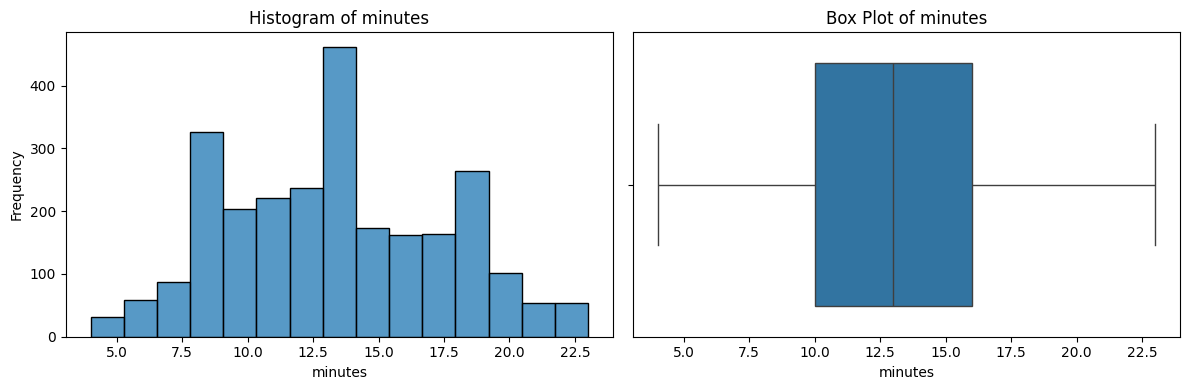

In [32]:
# Display charts for market_time
plot_histograms_boxplots(market_time)

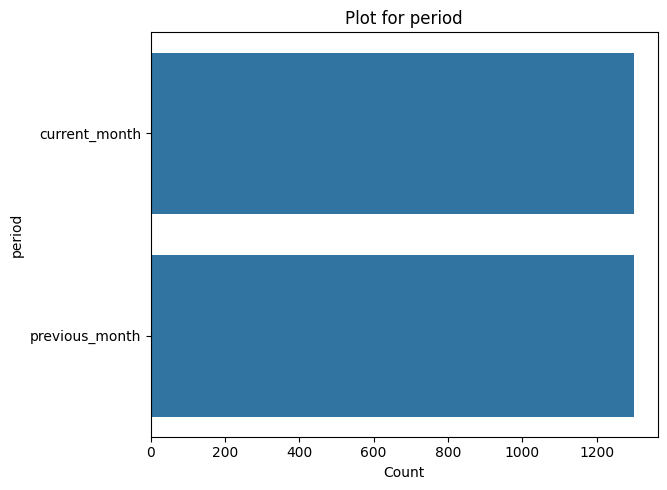

In [33]:
# Let's study the distribution of categorical features
plot_countplots(market_time)

Everithink is ok.

### money

In [34]:
# View summary statistics for numerical data
money.describe()

profit
count  1300.000000
mean      3.996631
std       1.013722
min       0.860000
25%       3.300000
50%       4.045000
75%       4.670000
max       7.430000

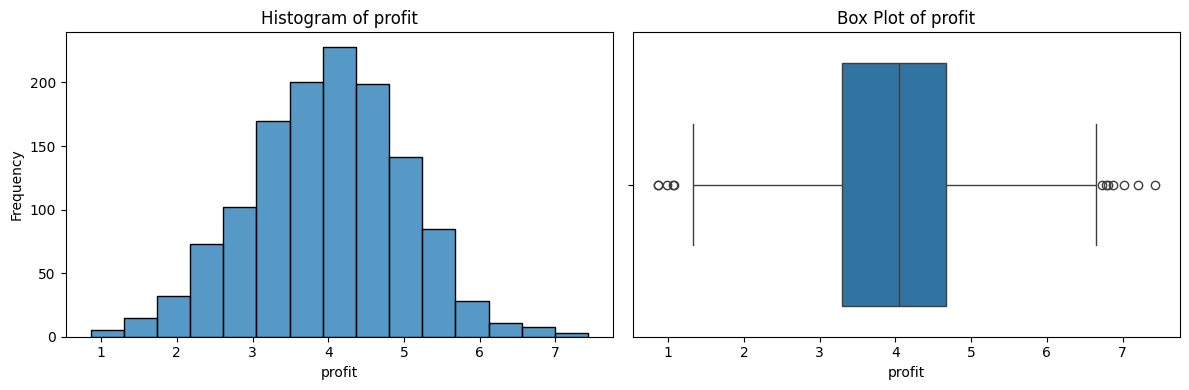

In [35]:
plot_histograms_boxplots(money)

There are outliers in the `profit` parameter.

**Conclusion**

- The data contains outliers and is unevenly distributed.

To select users with purchasing activity for at least three months, we can use users from the 'money' table, as this table stores data on the average monthly income of buyers over the past three months. Since there are no 0 values ​​in the table, all users made purchases within the specified period.

## <a name='Merging'></a> Data Merging

- Let's combine the market_file.csv, market_money.csv, and market_time.csv tables. We won't need the profit data from the money.csv file for the modeling.
- We need to keep in mind that revenue and time on site data are in a single column for all periods. In the final table, we'll create a separate column for each period.

In [36]:
# Checking columns in market_money
market_money.columns

Index(['period', 'revenue'], dtype='object')

In [37]:
market_money.duplicated().sum()

np.int64(742)

In [38]:
# Pivot by ID so that each ID appears in only one row
market_money = market_money.pivot_table(
index='id',       # Index by 'id'
columns='period', # Periods become columns
values='revenue', # Revenue values
aggfunc='sum'     # If we have multiple values, they need to be aggregated (e.g., summed)
)

# Rename columns by adding the suffix 'revenue_' to the 'period_money' categories
market_money.columns = [f"revenue_{col}" for col in market_money.columns]

# Check columns
market_money.shape

(1300, 3)

In [39]:
# Checking columns in market_time
market_time.columns

Index(['period', 'minutes'], dtype='object')

In [40]:
# Check that duplicates
market_time.duplicated().sum()

np.int64(2561)

In [41]:
# Pivot by ID so that each ID appears in only one row
market_time = market_time.pivot_table(
index='id', # Index by 'id'
columns='period', # Periods become columns
values='minutes', # Time values
aggfunc='sum' # If there are multiple values, aggregate
)

# Rename columns, adding the suffix 'time_' to the 'period_time' categories
market_time.columns = [f"time_{col}" for col in market_time.columns]

# Check columns
market_time.shape

(1300, 2)

In [42]:
# Combining data
df_full = market_file.join(market_money, on='id')
df_full = df_full.join(market_time, on='id')
df_full.head(10)

buyer_activity service_type marketing_consent  duration_days  \
id                                                                    
215348      Decreased      premium               yes            121   
215349      Decreased      premium               yes            819   
215350      Decreased     standard                no            539   
215351      Decreased     standard               yes            896   
215352      Decreased     standard                no           1064   
215353      Decreased     standard               yes            762   
215354      Decreased     standard               yes            431   
215355      Decreased     standard                no            284   
215356      Decreased     standard               yes            192   
215357      Decreased     standard               yes            154   

                    popular_category  avg_categories_per_visit  \
id                                                               
215348                 Baby Products                         6   
215349                 Baby Products                         4   
215350                 Home Textiles                         5   
215351                 Baby Products                         5   
215352                 Baby Products                         3   
215353                 Home Textiles                         4   
215354     Cosmetics and Accessories                         2   
215355                 Baby Products                         5   
215356     Cosmetics and Accessories                         2   
215357  Beauty and Health Appliances                         3   

        service_errors  pages_per_visit marketing_activity_6m_categorical  \
id                                                                          
215348               1                5                            medium   
215349               2                5                            medium   
215350               1                5                            medium   
215351               6                4                            medium   
215352               3                2                            medium   
215353               1                4                            medium   
215354               7                2                            medium   
215355               6                4                            medium   
215356               1                3                            medium   
215357               9                5                            medium   

       marketing_activity_current_month_categorical  \
id                                                    
215348                                         high   
215349                                       medium   
215350                                          low   
215351                                         high   
215352                                          low   
215353                                       medium   
215354                                          low   
215355                                       medium   
215356                                       medium   
215357                                         high   

       promo_purchases_share_categorical unpaid_products_quarter_categorical  \
id                                                                             
215348                               low                              medium   
215349                              high                              medium   
215350                               low                              medium   
215351                              high                                 low   
215352                              high                              medium   
215353                               low                              medium   
215354                               low                              medium   
215355                               low               

In [43]:
df_full.shape

(1300, 17)

In [44]:
df_full.duplicated().sum()

np.int64(11)

In [45]:
# Remove duplicates
df_full = df_full.drop_duplicates()

# Check that duplicates have been removed
df_full.duplicated().sum()

np.int64(0)

In [46]:
# Check for gaps
df_full.isna().sum()

buyer_activity                                  0
service_type                                    0
marketing_consent                               0
duration_days                                   0
popular_category                                0
avg_categories_per_visit                        0
service_errors                                  0
pages_per_visit                                 0
marketing_activity_6m_categorical               0
marketing_activity_current_month_categorical    0
promo_purchases_share_categorical               0
unpaid_products_quarter_categorical             0
revenue_current_month                           1
revenue_pre_previous_month                      3
revenue_previous_month                          3
time_current_month                              0
time_previous_month                             0
dtype: int64

In [47]:
# Drop rows with missing values
df_full.dropna(inplace=True)

# Check
df_full.isna().sum()

buyer_activity                                  0
service_type                                    0
marketing_consent                               0
duration_days                                   0
popular_category                                0
avg_categories_per_visit                        0
service_errors                                  0
pages_per_visit                                 0
marketing_activity_6m_categorical               0
marketing_activity_current_month_categorical    0
promo_purchases_share_categorical               0
unpaid_products_quarter_categorical             0
revenue_current_month                           0
revenue_pre_previous_month                      0
revenue_previous_month                          0
time_current_month                              0
time_previous_month                             0
dtype: int64

In [48]:
# Checking the dimensionality
df_full.shape

(1285, 17)

In [49]:
# Проверка основной информации
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1285 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   buyer_activity                                1285 non-null   object 
 1   service_type                                  1285 non-null   object 
 2   marketing_consent                             1285 non-null   object 
 3   duration_days                                 1285 non-null   int64  
 4   popular_category                              1285 non-null   object 
 5   avg_categories_per_visit                      1285 non-null   int64  
 6   service_errors                                1285 non-null   int64  
 7   pages_per_visit                               1285 non-null   int64  
 8   marketing_activity_6m_categorical             1285 non-null   object 
 9   marketing_activity_current_month_categorical  1285 non-null  

## <a name='Correlation'></a> Correlation Analysis

- We'll conduct a correlation analysis of the features on a quantitative scale in the final modeling table.
- We'll draw conclusions about multicollinearity and, if necessary, eliminate it.

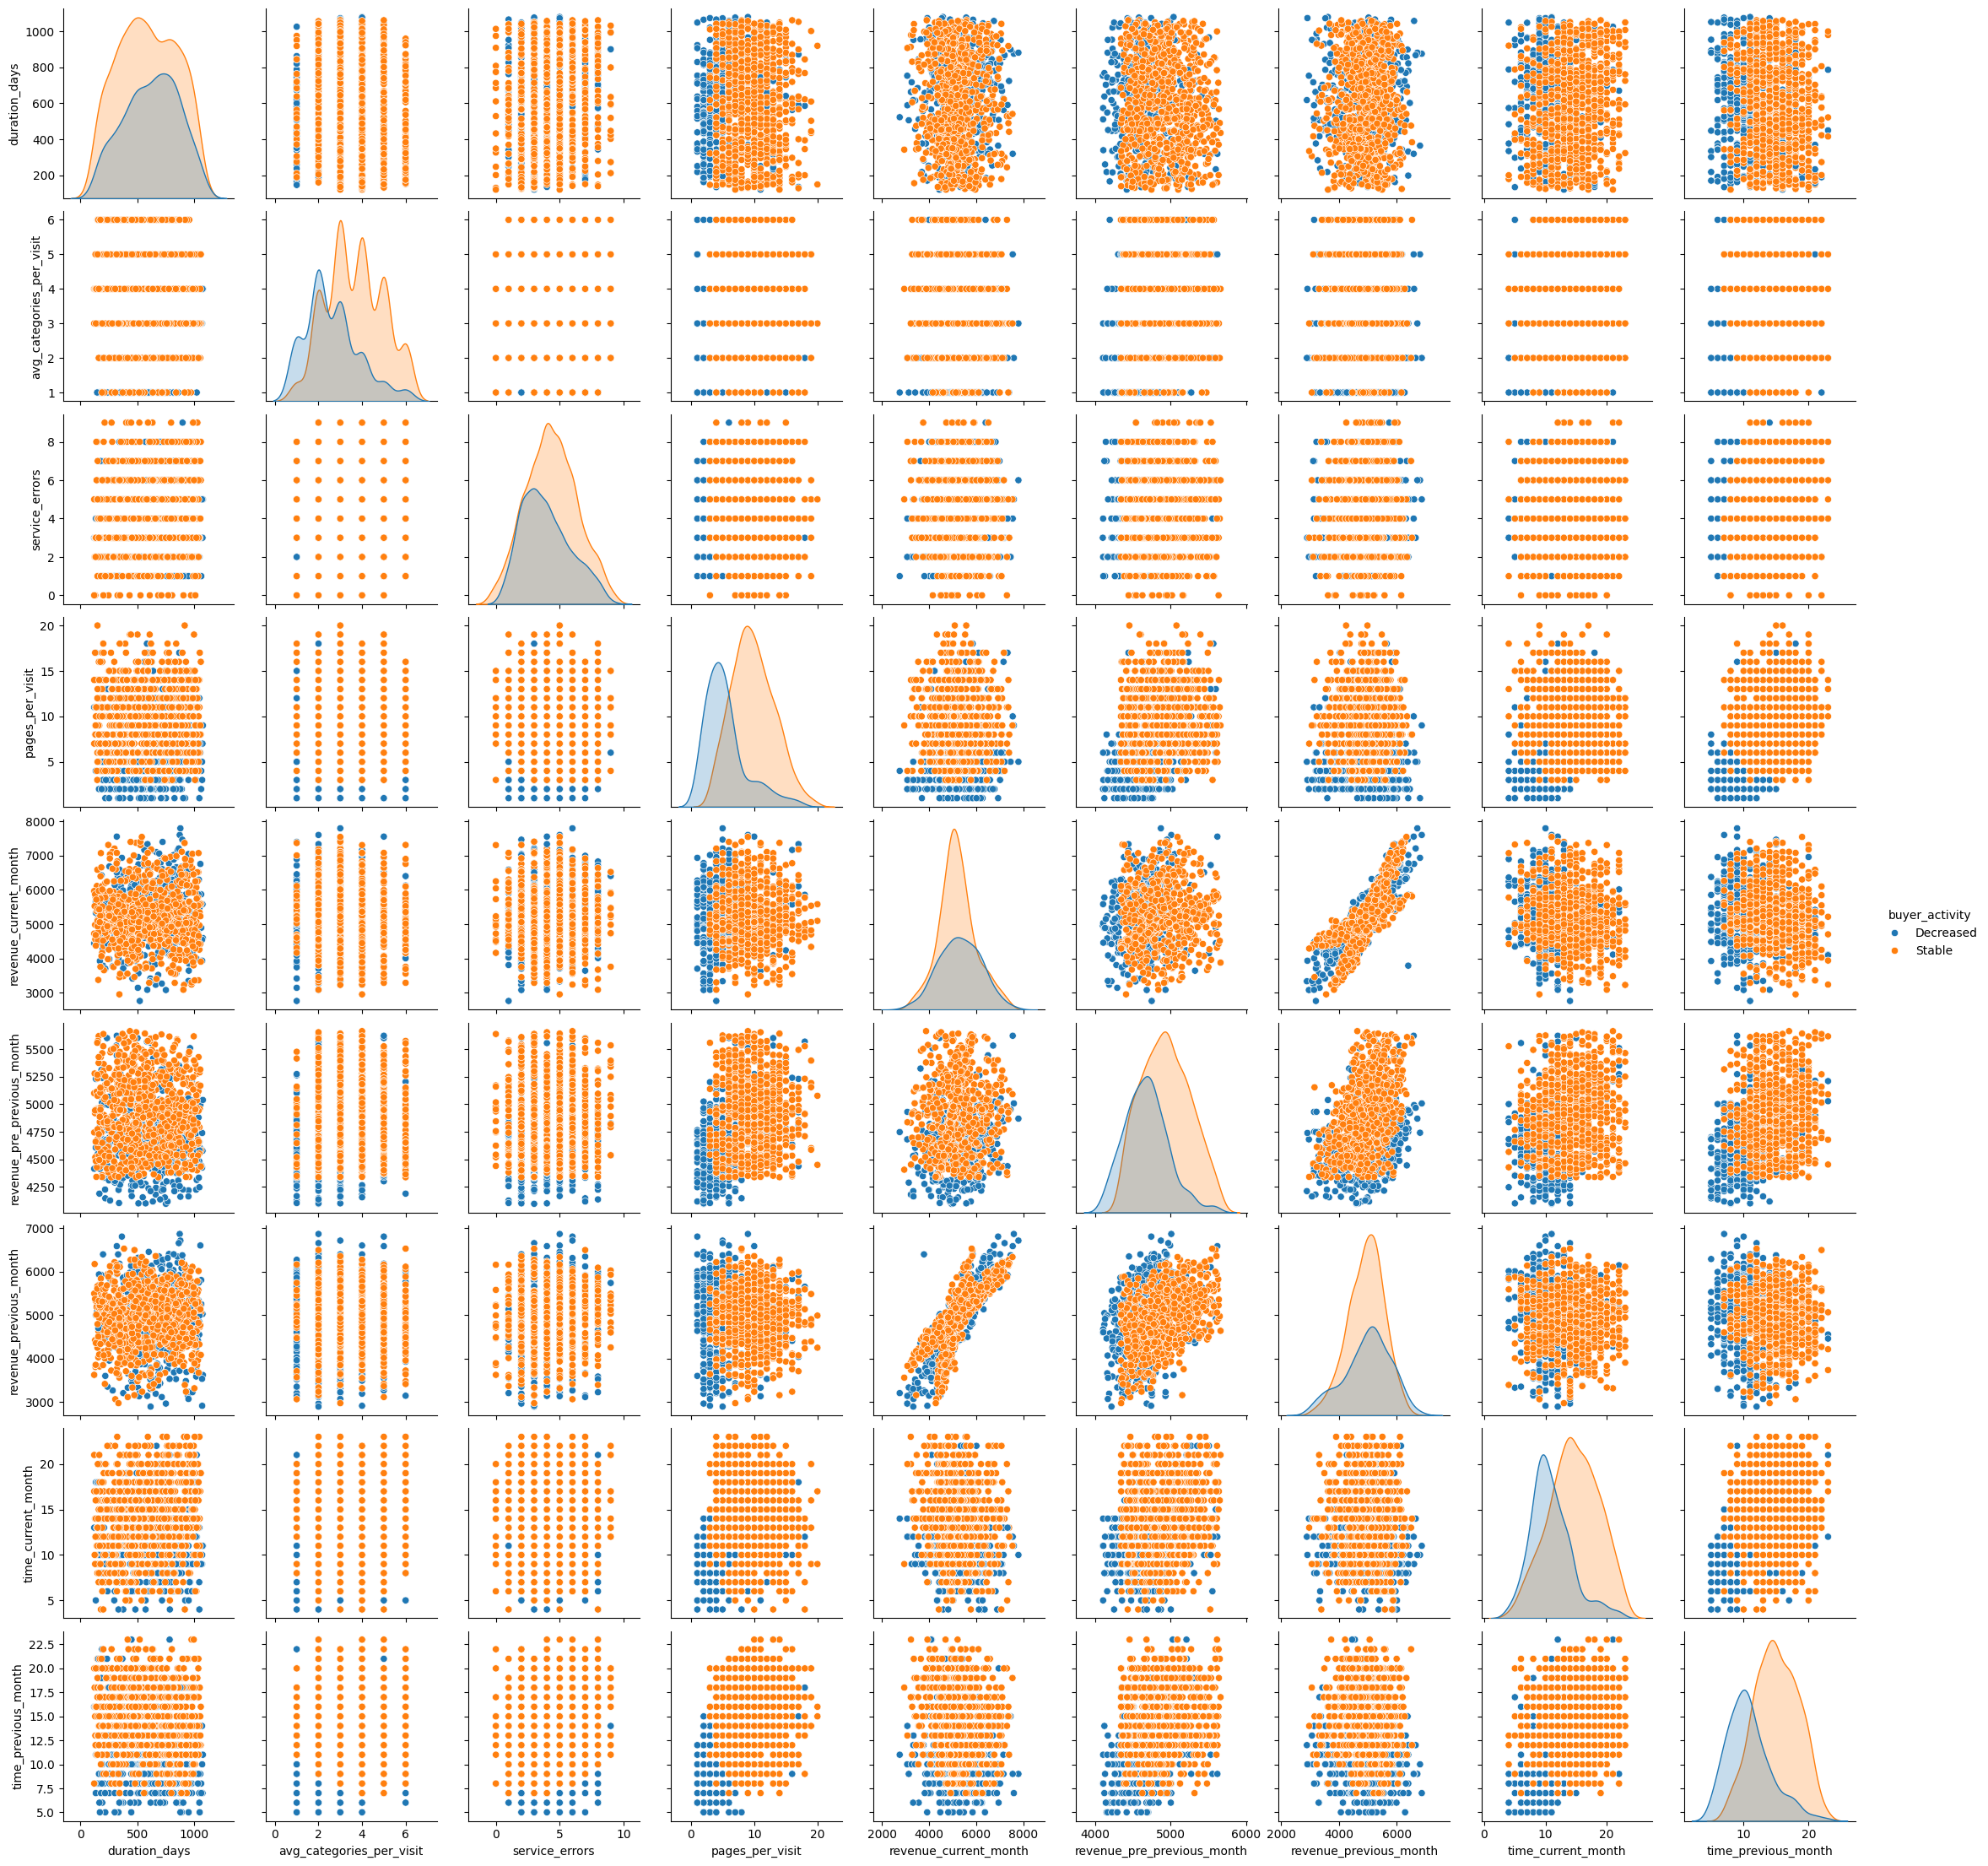

In [50]:
# Pairplotting for Numeric Variables
# hue='Buyer_Activity' allows you to distinguish data groups by color depending on the value of this variable.
sns.pairplot(df_full, hue='buyer_activity')

# Displaying Plots
plt.show()

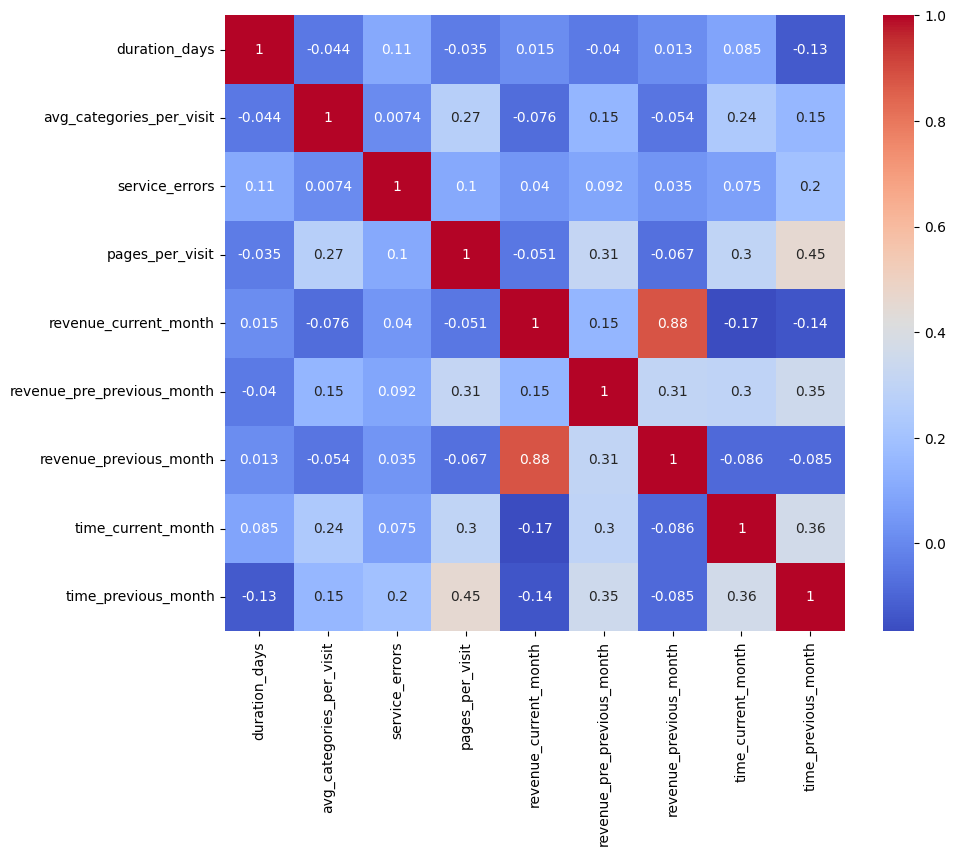

In [51]:
# Selecting only numeric columns from a DataFrame
numeric_cols = df_full.select_dtypes(include=['number']).columns

# Calculating the correlation matrix using Spearman's method
# Spearman's method is used to analyze monotonic relationships between variables, unlike the standard Pearson method.
correlation_matrix = df_full[numeric_cols].corr(method='spearman')

# Plotting a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Let's try the Phi-K method, which is used to analyze correlations between numerical and categorical features, helps to identify not only linear dependencies, but also more complex (including nonlinear) relationships.

A correlation higher than 0.75 was not found, meaning there is no multicollinearity between the features.

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1060879998.py:20: SyntaxWarning: invalid escape sequence '\p'
  title='Category - "Decreased buyer_activity", $\phi_K$',


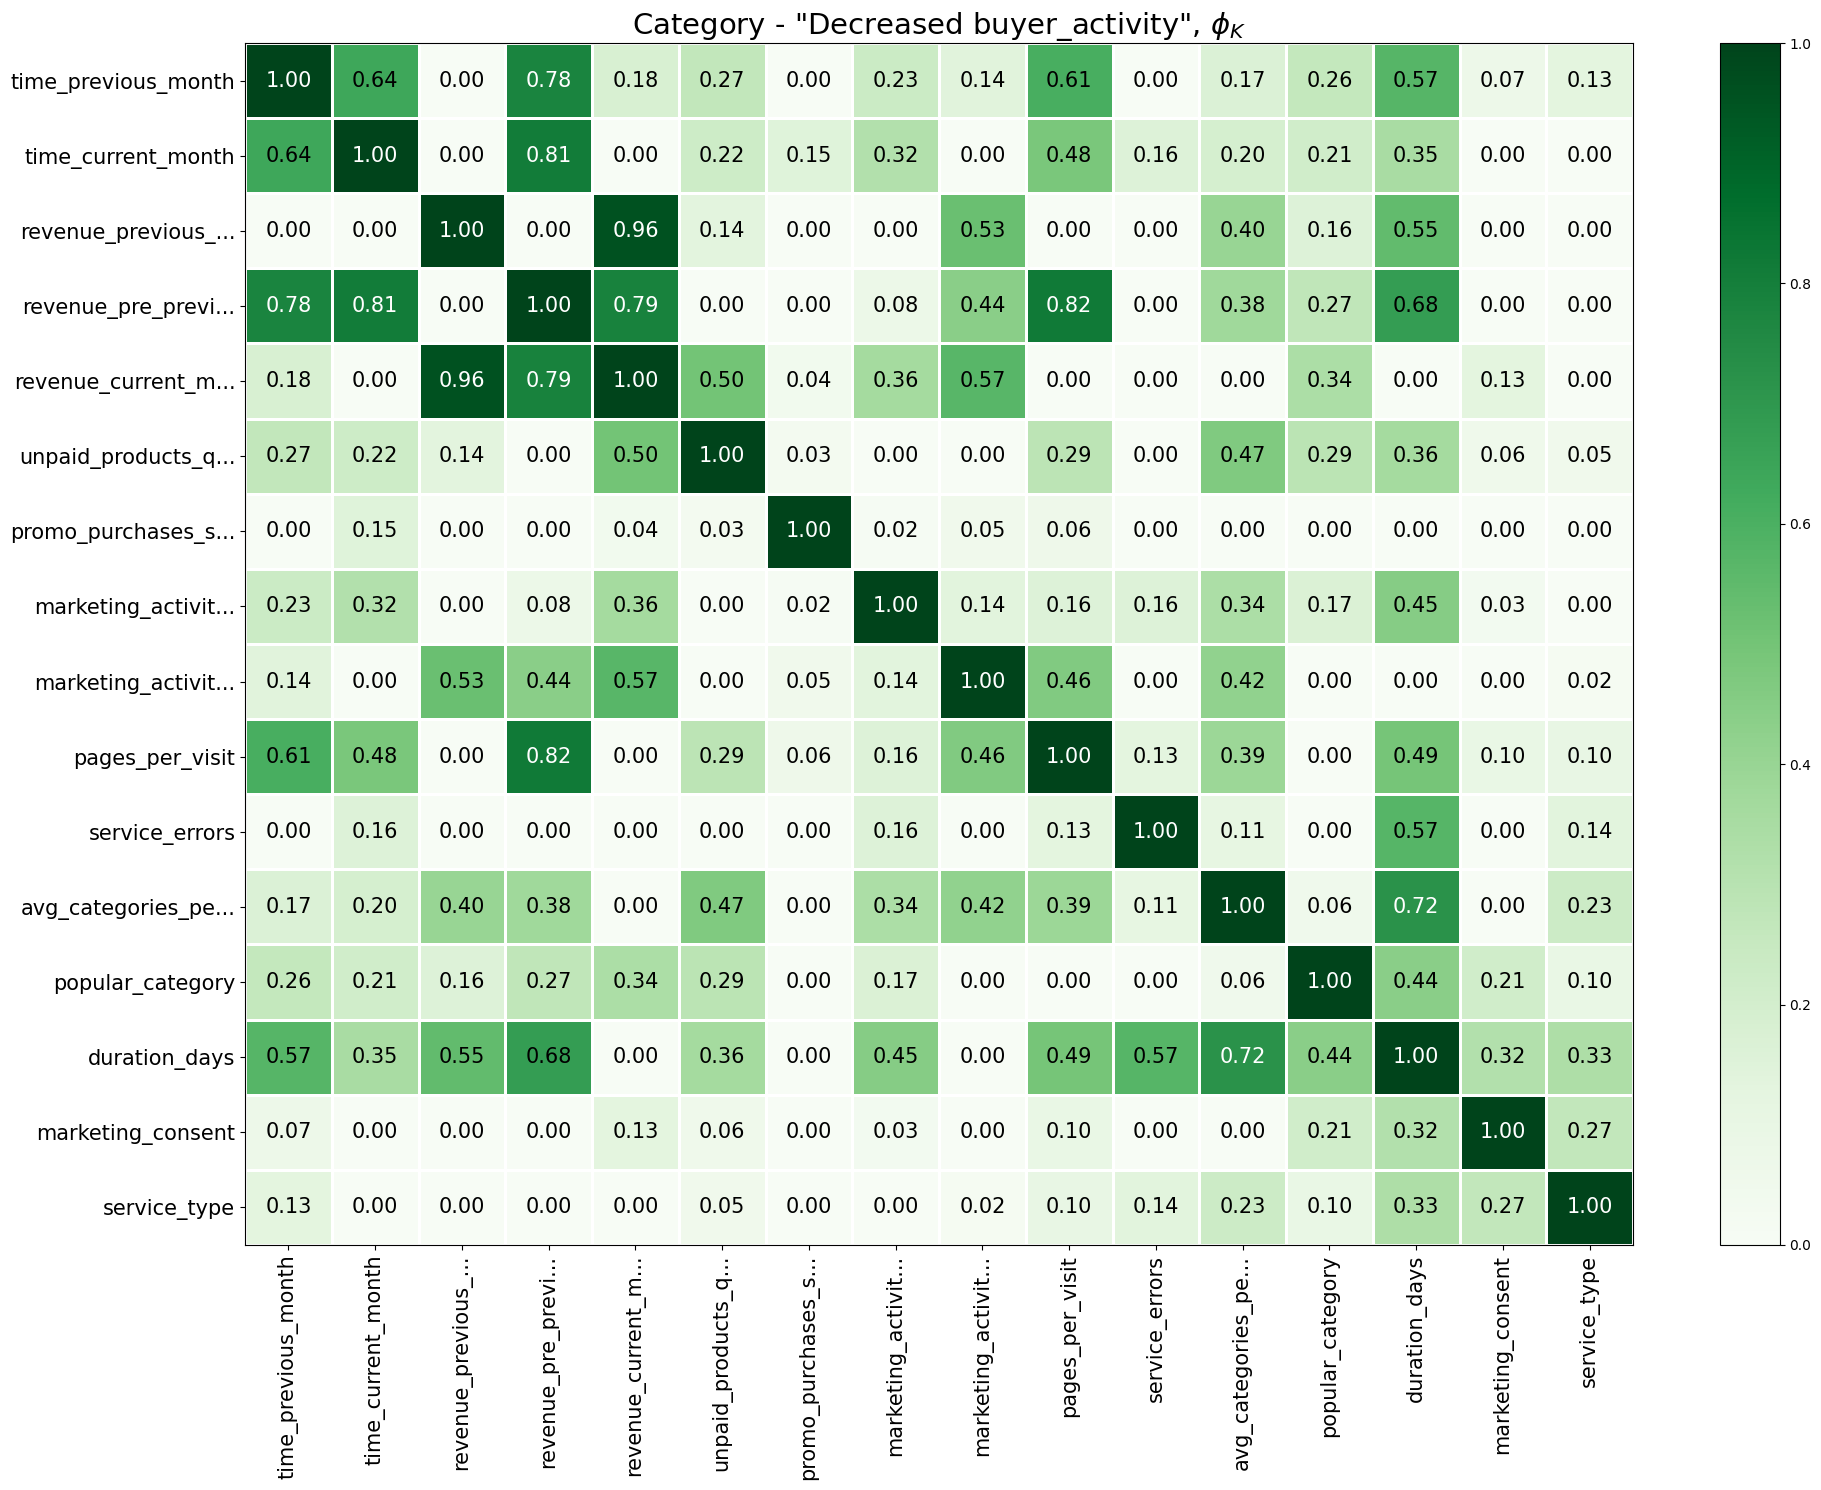

In [52]:
# Filter the DataFrame by the "Decreased" category in the 'buyer_activity' column and remove this column.
# Create a Phi-K correlation matrix for the numerical features in this category.
phik_overview_declined = phik_matrix(
df_full[df_full['buyer_activity'] == 'Decreased'].drop('buyer_activity', axis=1), # Filter and remove a column
interval_cols=numeric_cols, # List of numerical features for analysis
bins=100 # Number of bins (groups) for correlation calculation
)

# Create a correlation heatmap for the "Decreased" category.
# phik_overview_declined.values ​​- the correlation matrix obtained in the previous step
# x_labels and y_labels - axis labels; we use the column names from the resulting matrix
# The vmin and vmax parameters set the limits for the color scale (from 0 to 1 for Phi-K)
# color_map sets the color scheme, and title sets the plot title.
plot_correlation_matrix(
phik_overview_declined.values, # Correlation matrix values
x_labels=phik_overview_declined.columns, #ъ
y_labels=phik_overview_declined.index,
vmin=0, vmax=1, # Color scale limits
color_map='Greens', # Color scheme
title='Category - "Decreased buyer_activity", $\phi_K$',
fontsize_factor=1.5,
figsize=(20, 15)
)

- `revenue_current_month` is highly correlated with `revenue_previous_month`.
- `revenue_pre_previous_month` is highly correlated with `time_current_month`, `time_previous_month`, `revenue_current_month`, and `pages_per_visit`.

**The following conclusions can be drawn:**

- A promotion may have occurred in the previous month that significantly impacted revenue;
- The revenue indicators for the current month, as well as the current month's minutes, are a leak, as they can only be recorded after the month for which the forecast is required;

<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-551555239.py:16: SyntaxWarning: invalid escape sequence '\p'
  title='Category - "Stable buyer_activity", $\phi_K$',


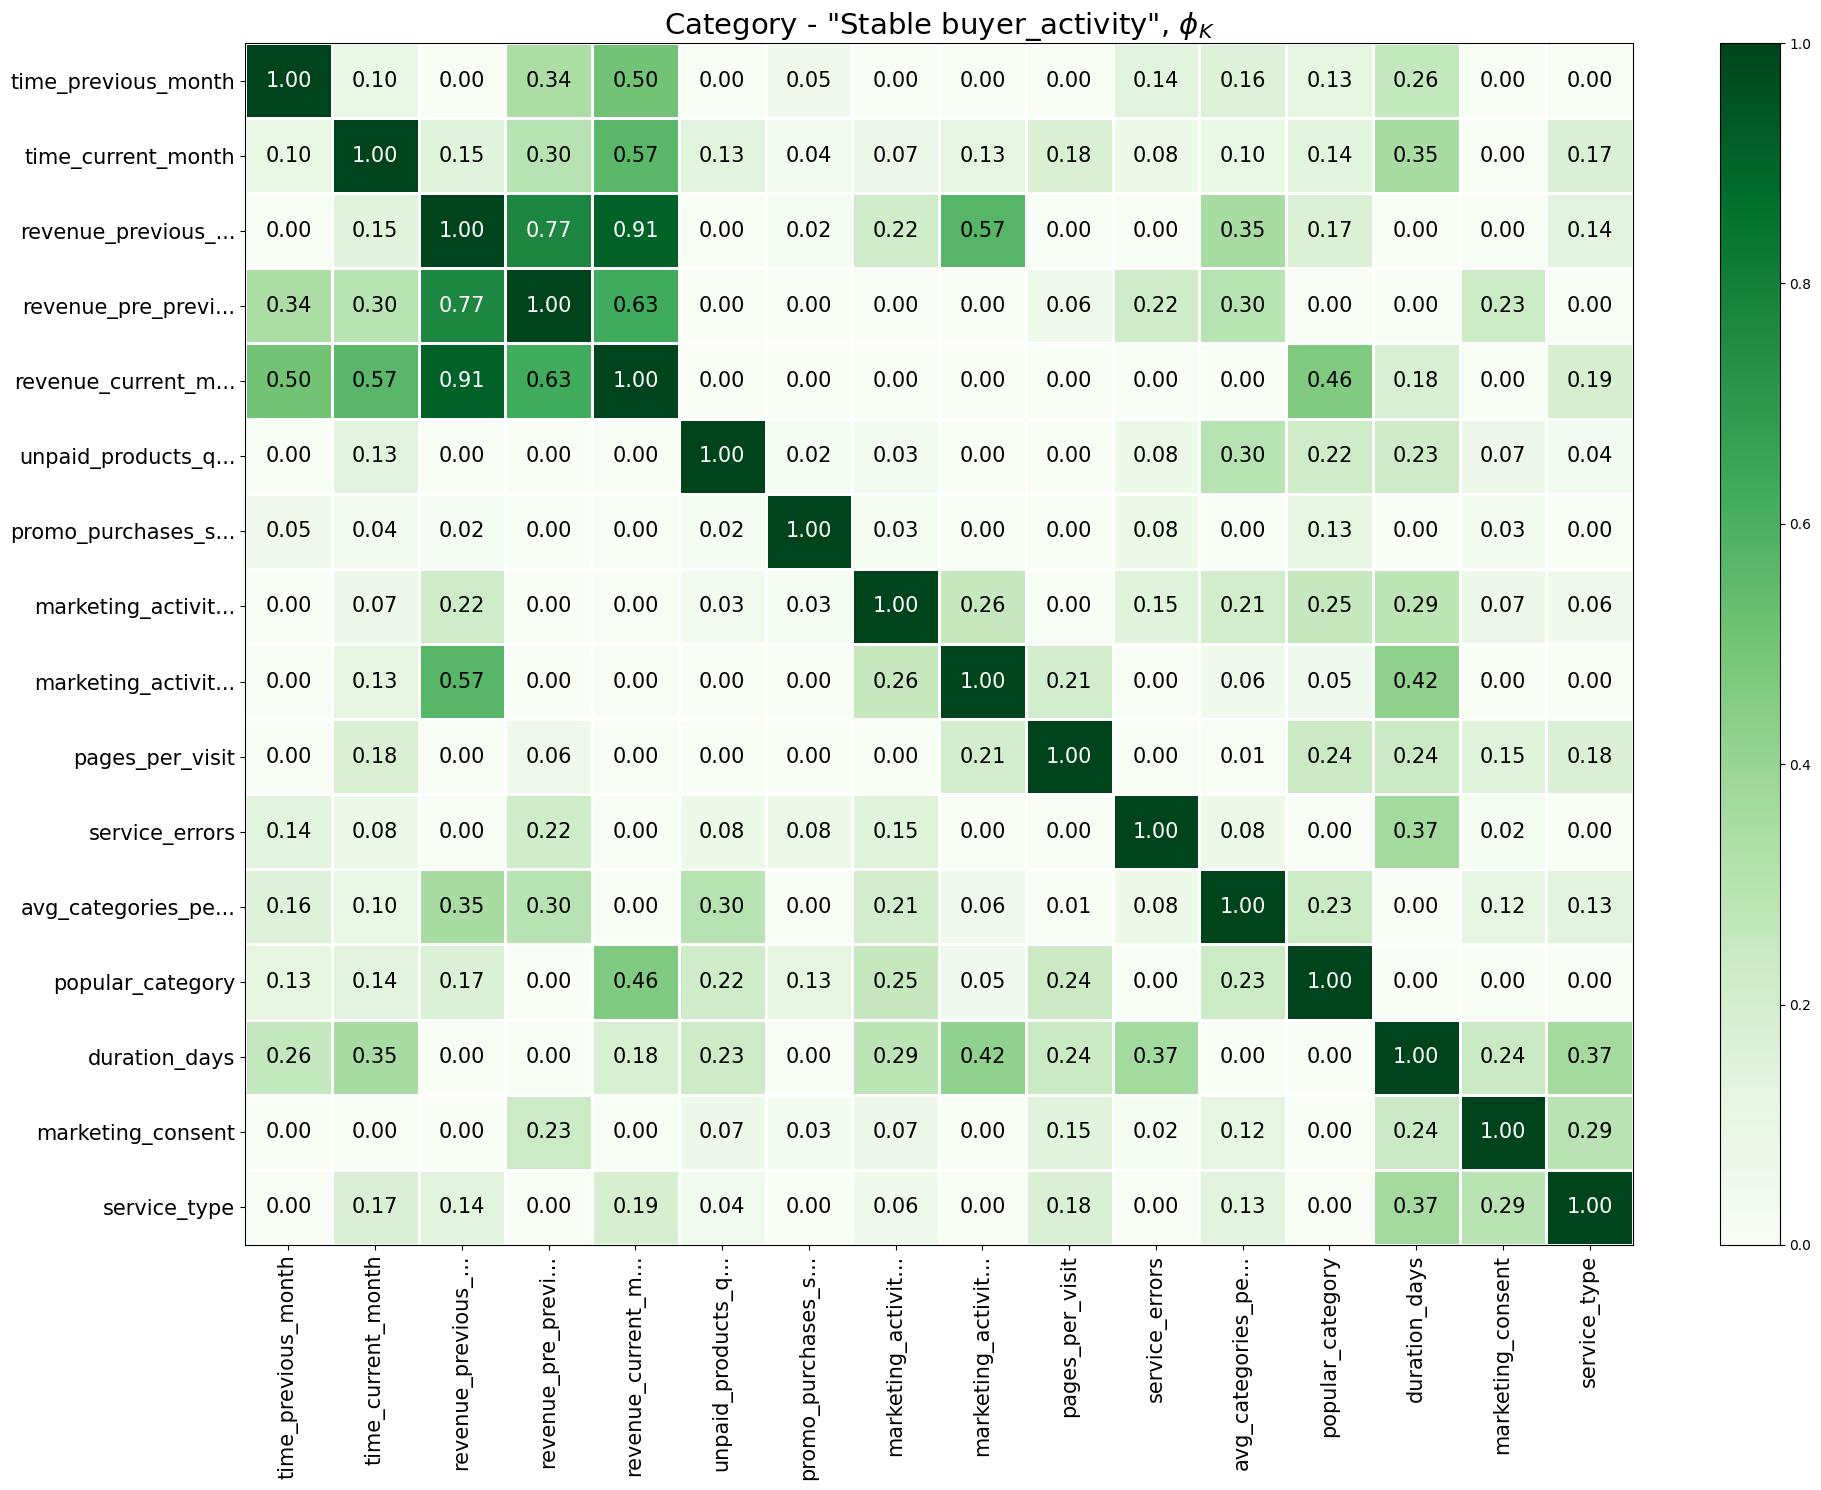

In [53]:
# Filter the DataFrame by the "Stable" category in the 'buyer_activity' column and remove this column again.
# Build a Phi-K correlation matrix for the numerical features in this category.
phik_overview_stable = phik_matrix(
df_full[df_full['buyer_activity']=='Stable'].drop(['buyer_activity'],axis=1),
interval_cols=numeric_cols, bins=100)

# Build a correlation heatmap for the "Stable" category.
# phik_overview_stable.values ​​- correlation matrix for this category
# x_labels and y_labels are again defined based on the column names.
plot_correlation_matrix(
phik_overview_stable.values, # Correlation matrix values
x_labels=phik_overview_stable.columns,
y_labels=phik_overview_stable.index,
vmin=0, vmax=1, # Color scale limits
color_map='Greens',
title='Category - "Stable buyer_activity", $\phi_K$',
fontsize_factor=1.5,
figsize=(20, 15)
)

We will remove `revenue_pre_previous_month`, `revenue_current_month` and `time_current_month` due to leakage risks, and apply the regularization method to other correlated parameters.

In [54]:
df_full = df_full.drop([
    'revenue_pre_previous_month',
    'revenue_current_month',
    'time_current_month'], axis=1)

df_full.head()

buyer_activity service_type marketing_consent  duration_days  \
id                                                                    
215349      Decreased      premium               yes            819   
215350      Decreased     standard                no            539   
215351      Decreased     standard               yes            896   
215352      Decreased     standard                no           1064   
215353      Decreased     standard               yes            762   

       popular_category  avg_categories_per_visit  service_errors  \
id                                                                  
215349    Baby Products                         4               2   
215350    Home Textiles                         5               1   
215351    Baby Products                         5               6   
215352    Baby Products                         3               3   
215353    Home Textiles                         4               1   

        pages_per_visit marketing_activity_6m_categorical  \
id                                                          
215349                5                            medium   
215350                5                            medium   
215351                4                            medium   
215352                2                            medium   
215353                4                            medium   

       marketing_activity_current_month_categorical  \
id                                                    
215349                                       medium   
215350                                          low   
215351                                         high   
215352                                          low   
215353                                       medium   

       promo_purchases_share_categorical unpaid_products_quarter_categorical  \
id                                                                             
215349                              high                              medium   
215350                               low                              medium   
215351                              high                                 low   
215352                              high                              medium   
215353                               low                              medium   

        revenue_previous_month  time_previous_month  
id                                                   
215349                  5216.0                   12  
215350                  5457.5                    8  
215351                  6158.0                   11  
215352                  5807.5                    8  
215353                  4738.5                   10

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-882640142.py:14: SyntaxWarning: invalid escape sequence '\p'
  title='Category - "Decreased buyer_activity", $\phi_K$',


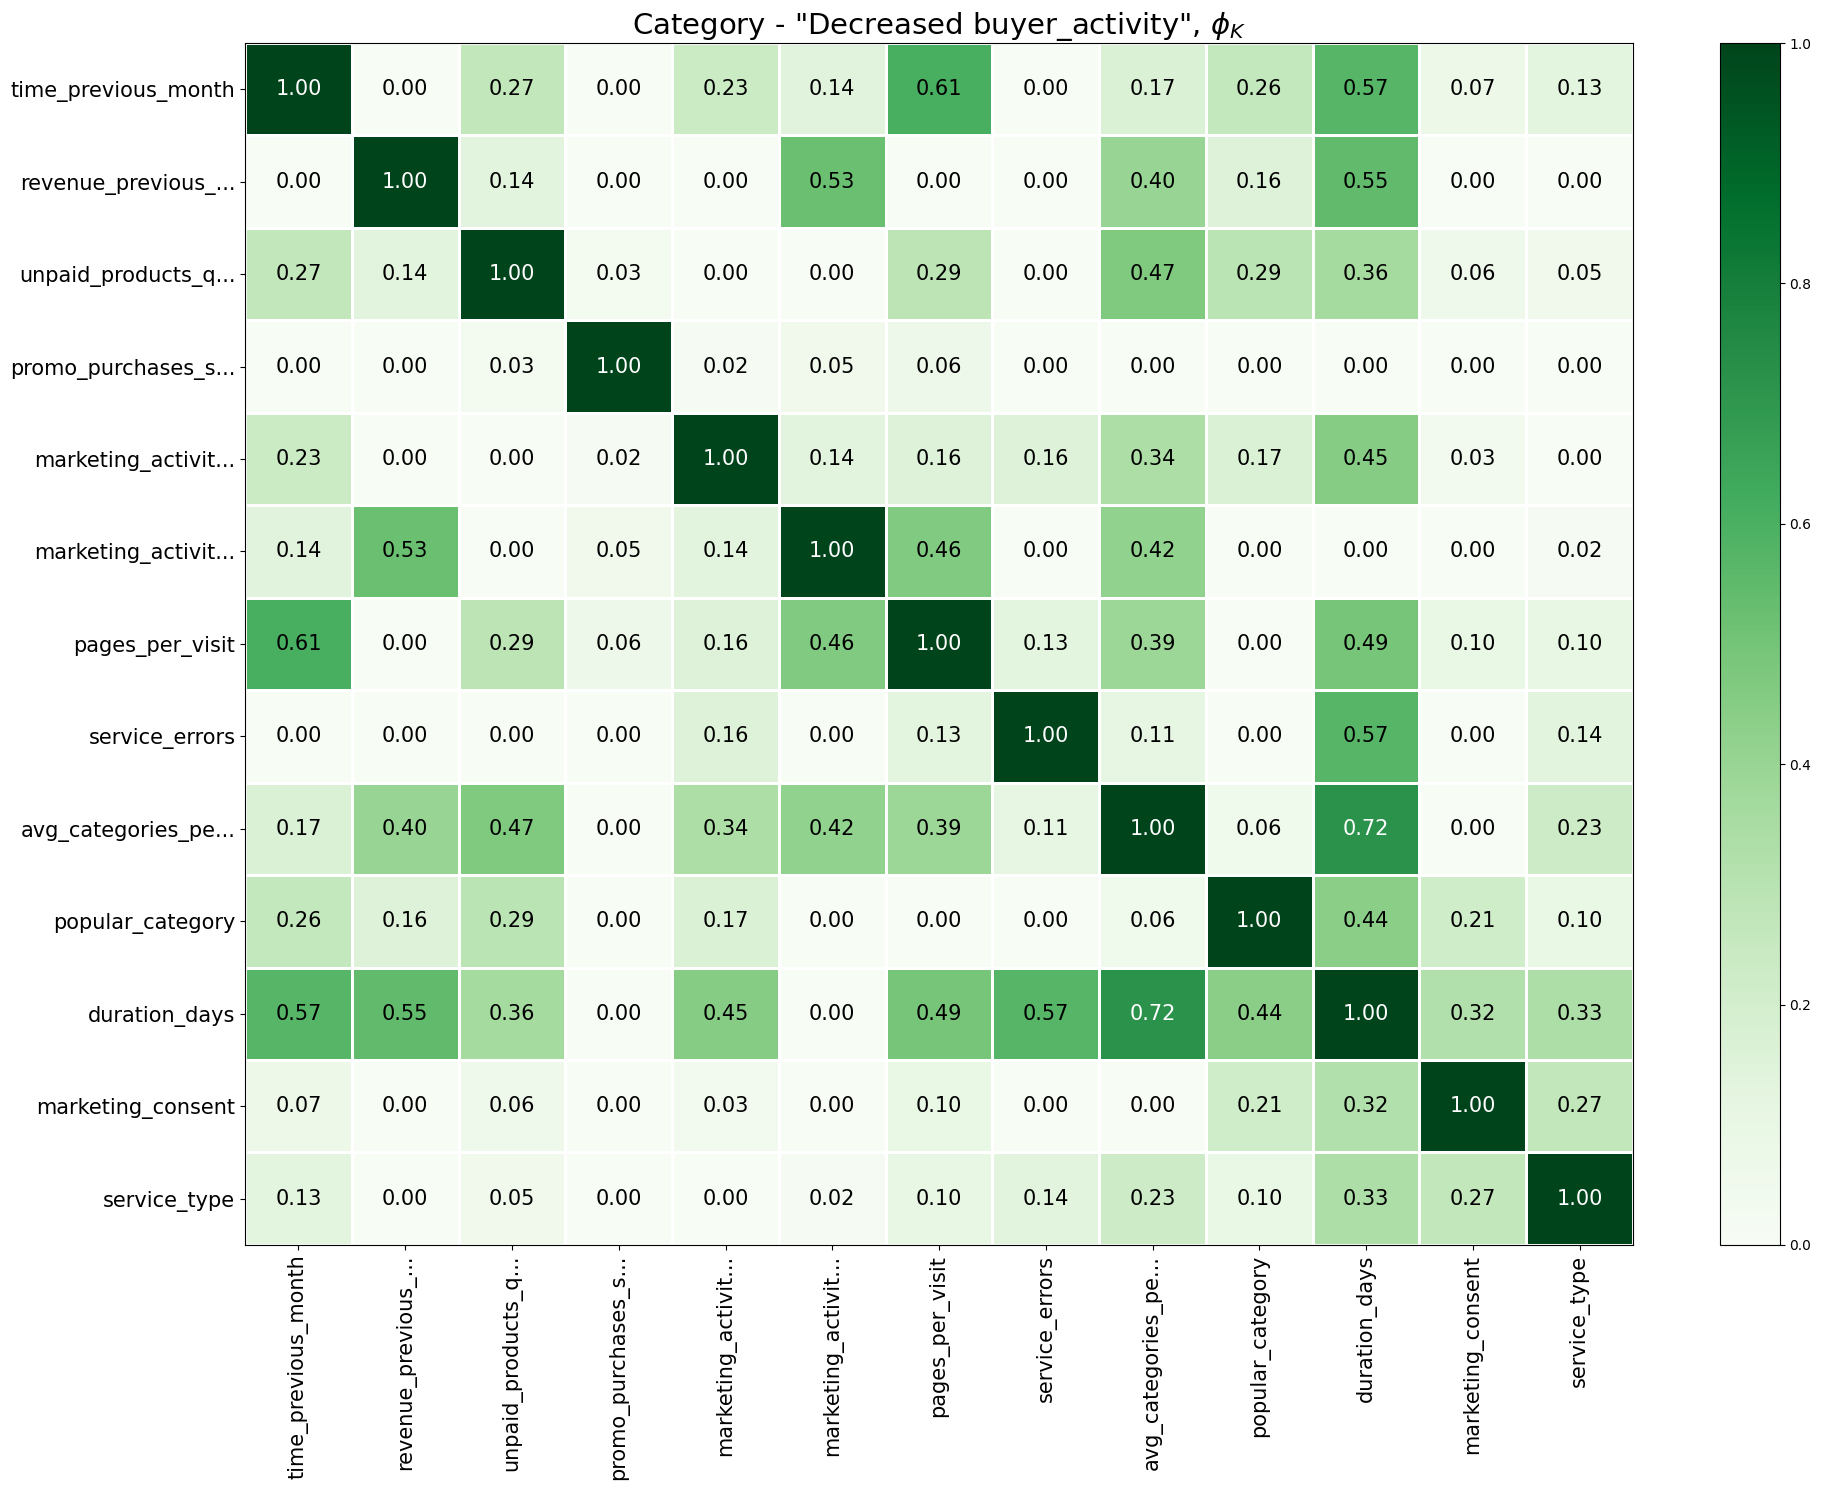

In [55]:
# Check the correlation again
phik_overview_declined = phik_matrix(
df_full[df_full['buyer_activity'] == 'Decreased'].drop('buyer_activity', axis=1), # Filter and remove a column
interval_cols=numeric_cols, # List of numerical features for analysis
bins=100 # Number of bins (groups) for calculating the correlation
)

plot_correlation_matrix(
phik_overview_declined.values, # Correlation matrix values
x_labels=phik_overview_declined.columns, #ъ
y_labels=phik_overview_declined.index,
vmin=0, vmax=1, # Color scale limits
color_map='Greens', # Color scheme
title='Category - "Decreased buyer_activity", $\phi_K$',
fontsize_factor=1.5,
figsize=(20, 15)
)

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-583435918.py:11: SyntaxWarning: invalid escape sequence '\p'
  title='Category - "Stable buyer_activity", $\phi_K$',


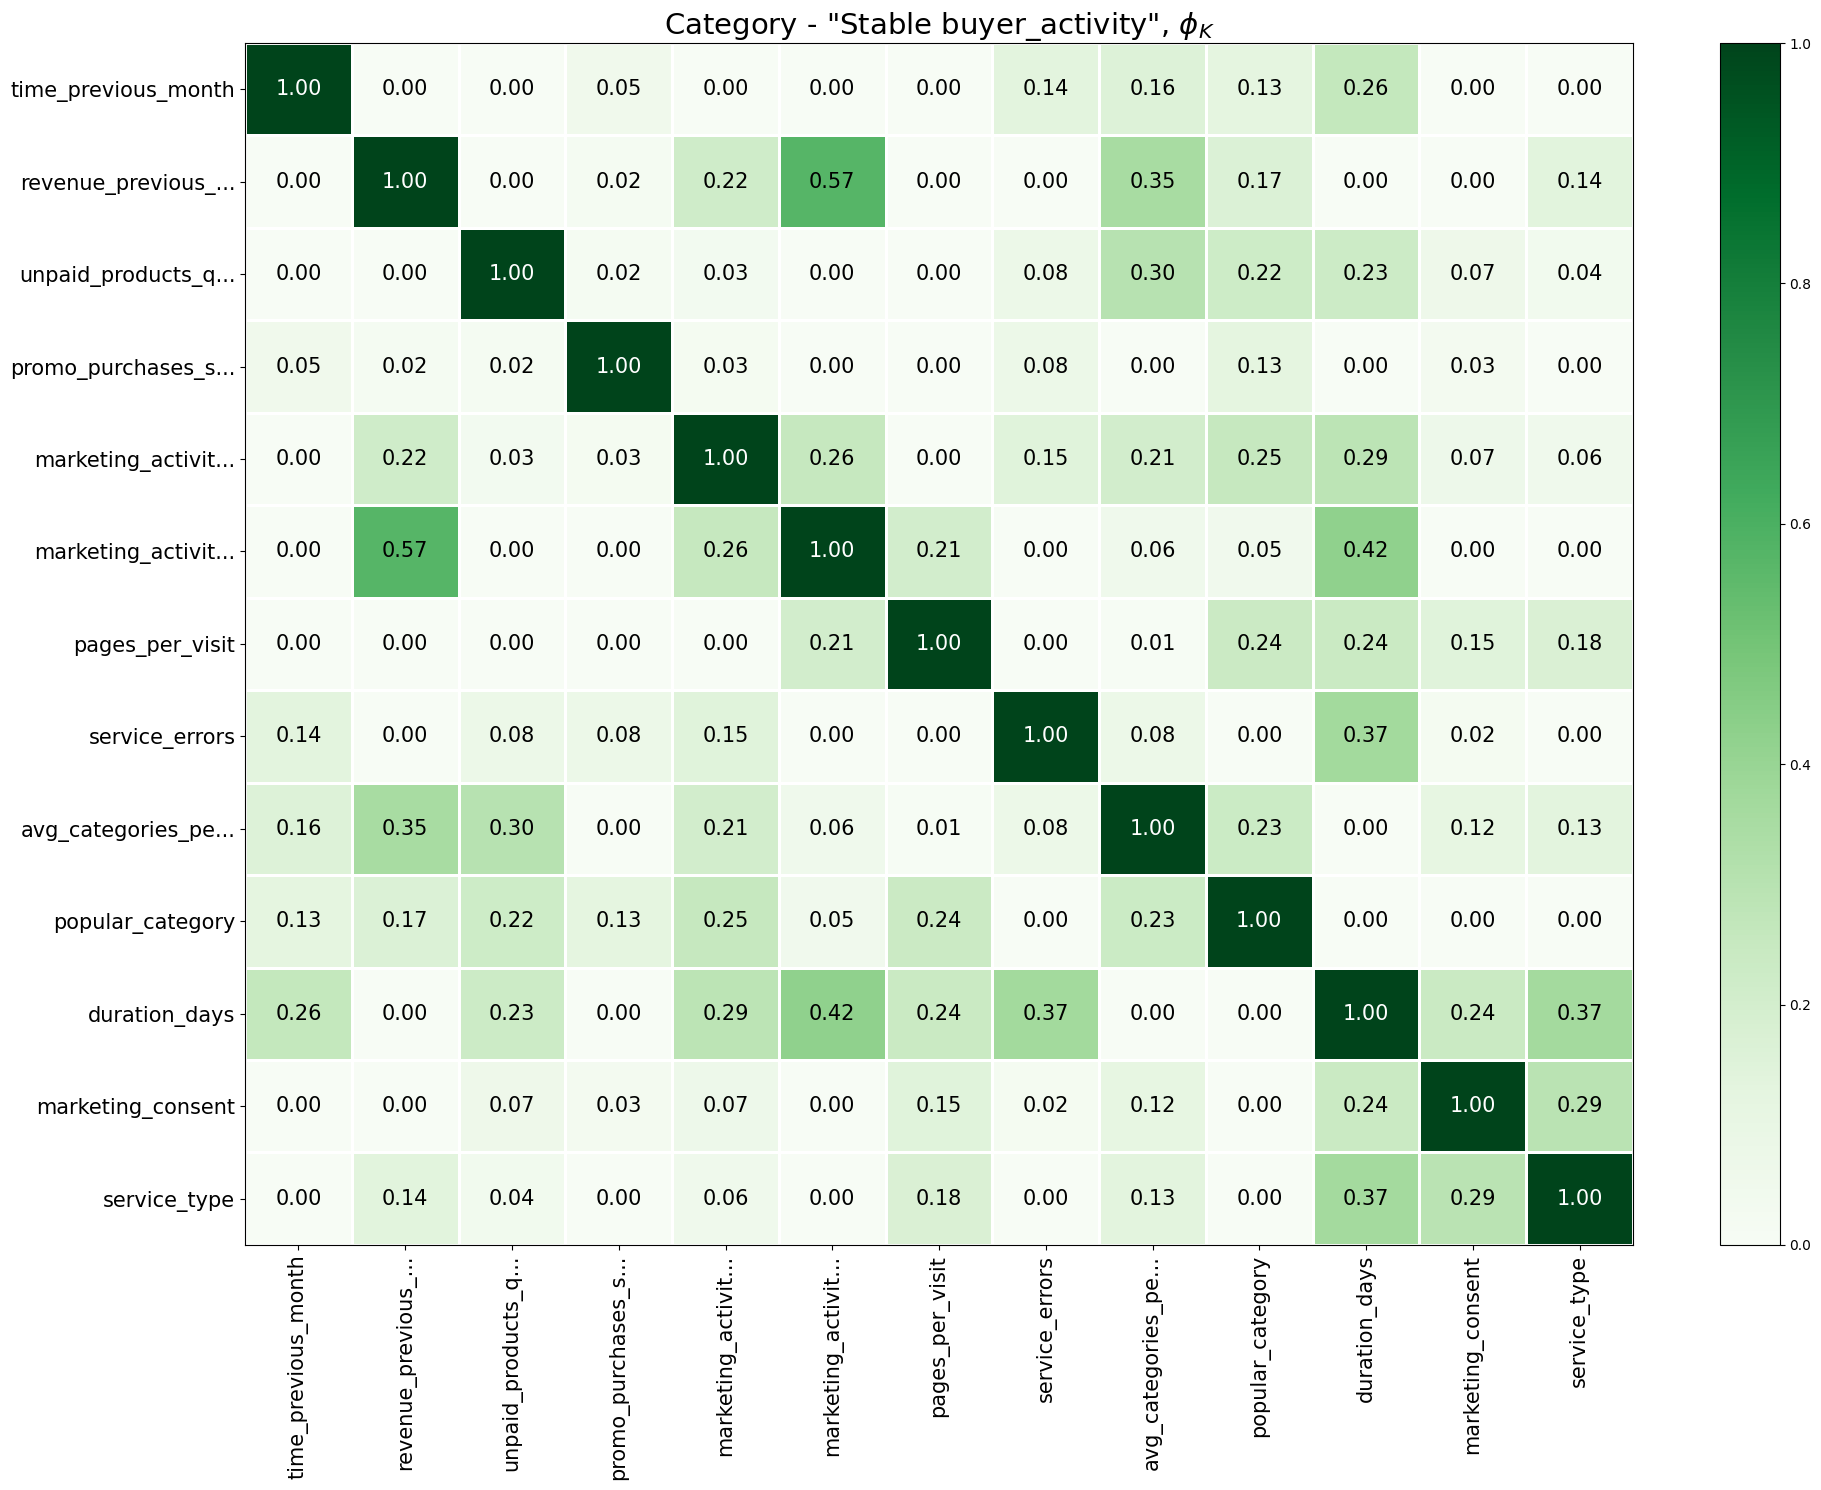

In [56]:
phik_overview_stable = phik_matrix(
df_full[df_full['buyer_activity']=='Stable'].drop(['buyer_activity'],axis=1),
interval_cols=numeric_cols, bins=100)

plot_correlation_matrix(
phik_overview_stable.values, # Correlation matrix values
x_labels=phik_overview_stable.columns,
y_labels=phik_overview_stable.index,
vmin=0, vmax=1, # Color scale limits
color_map='Greens',
title='Category - "Stable buyer_activity", $\phi_K$',
fontsize_factor=1.5,
figsize=(20, 15)
)

There is no obvious multicollinearity.

## <a name='Pipelines'></a> Model Building using Pipelines

1. We will use ColumnTransformer to process quantitative and categorical features separately in the pipeline. We'll use at least two encoders to encode categorical features, and two scalers to scale quantitative features. For each model, we'll prepare data with different encodings and scaling.

2. We will train four models: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), and SVC(). For each model, we'll select at least one hyperparameter and choose an appropriate metric for the problem, justifying our choice. We'll use this metric when selecting hyperparameters.

3. We will select the best model using the specified metric, using one of the following strategies:

4. We will use pipelines and hyperparameter selection tools for each model separately to select the best model.

5. We use one common pipeline for all models and a hyperparameter selection tool that will return the best model.

For this task, I will choose the **ROC-AUC** metric, since it is well suited for assessing the quality of classification in problems with imbalanced classes, as this may be the case in our case with the "Buyer_Activity" features.

In [57]:
# Data validation before training
detailed_df_analysis(df_full, 'Full dataset')

--- Main information about dataset: Full dataset ---
<class 'pandas.core.frame.DataFrame'>
Index: 1285 entries, 215349 to 216647
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   buyer_activity                                1285 non-null   object 
 1   service_type                                  1285 non-null   object 
 2   marketing_consent                             1285 non-null   object 
 3   duration_days                                 1285 non-null   int64  
 4   popular_category                              1285 non-null   object 
 5   avg_categories_per_visit                      1285 non-null   int64  
 6   service_errors                                1285 non-null   int64  
 7   pages_per_visit                               1285 non-null   int64  
 8   marketing_activity_6m_categorical             1285 non-null   object 
 9   marketin

buyer_activity service_type marketing_consent  duration_days  \
id                                                                    
215349      Decreased      premium               yes            819   
215350      Decreased     standard                no            539   
215351      Decreased     standard               yes            896   
215352      Decreased     standard                no           1064   
215353      Decreased     standard               yes            762   

       popular_category  avg_categories_per_visit  service_errors  \
id                                                                  
215349    Baby Products                         4               2   
215350    Home Textiles                         5               1   
215351    Baby Products                         5               6   
215352    Baby Products                         3               3   
215353    Home Textiles                         4               1   

        pages_per_visit marketing_activity_6m_categorical  \
id                                                          
215349                5                            medium   
215350                5                            medium   
215351                4                            medium   
215352                2                            medium   
215353                4                            medium   

       marketing_activity_current_month_categorical  \
id                                                    
215349                                       medium   
215350                                          low   
215351                                         high   
215352                                          low   
215353                                       medium   

       promo_purchases_share_categorical unpaid_products_quarter_categorical  \
id                                                                             
215349                              high                              medium   
215350                               low                              medium   
215351                              high                                 low   
215352                              high                              medium   
215353                               low                              medium   

        revenue_previous_month  time_previous_month  
id                                                   
215349                  5216.0                   12  
215350                  5457.5                    8  
215351                  6158.0                   11  
215352                  5807.5                    8  
215353                  4738.5                   10



Missing values:
                                              count  percentage
buyer_activity                                    0         0.0
service_type                                      0         0.0
marketing_consent                                 0         0.0
duration_days                                     0         0.0
popular_category                                  0         0.0
avg_categories_per_visit                          0         0.0
service_errors                                    0         0.0
pages_per_visit                                   0         0.0
marketing_activity_6m_categorical                 0         0.0
marketing_activity_current_month_categorical      0         0.0
promo_purchases_share_categorical                 0         0.0
unpaid_products_quarter_categorical               0         0.0
revenue_previous_month                            0         0.0
time_previous_month                               0         0.0 

Number of duplicates

In [58]:
df_full['buyer_activity'].value_counts()

buyer_activity
Stable       802
Decreased    483
Name: count, dtype: int64

In [59]:
# Initialize the label encoder for the target variable 'buyer_activity'
le = LabelEncoder()

# Define features (X) and the target variable (y)
X = df_full.drop(['buyer_activity'], axis=1)
y = df_full['buyer_activity']

# Split the data into training and test sets using stratified splitting
# Stratify is important here because classes are unbalanced
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# Encode the target
# Fit on train, transform on both to avoid data leakage
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [60]:
print("Class Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
# Expected: {'Decreased': 0, 'Stable': 1}

Class Mapping: {'Decreased': np.int64(0), 'Stable': np.int64(1)}


In [61]:
# Define Feature Groups
ohe_columns = [
    'service_type',
    'marketing_consent',
    'popular_category',
    'promo_purchases_share_categorical'
]

ord_columns = [
    'marketing_activity_6m_categorical',
    'marketing_activity_current_month_categorical',
    'unpaid_products_quarter_categorical'
]

num_columns = [
    'duration_days',
    'avg_categories_per_visit',
    'service_errors',
    'pages_per_visit',
    'revenue_previous_month',
    'time_previous_month'
]

In [62]:
def objective(trial):
    # Suggest Scaler
    scaler_name = trial.suggest_categorical('scaler', ['standard', 'minmax', 'passthrough'])
    if scaler_name == 'standard':
        scaler_obj = StandardScaler()
    elif scaler_name == 'minmax':
        scaler_obj = MinMaxScaler()
    else:
        scaler_obj = 'passthrough'

    # Define Preprocessor
    data_preprocessor = ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_columns),
        ('num', scaler_obj, num_columns)
    ], remainder='passthrough')

    # Suggest Classifier
    classifier_name = trial.suggest_categorical('classifier', ['DecisionTree', 'KNN', 'LogisticRegression', 'SVC_Linear', 'SVC_RBF'])

    if classifier_name == 'DecisionTree':
        max_depth = trial.suggest_int('dt_max_depth', 2, 5)
        max_features = trial.suggest_int('dt_max_features', 2, 5)
        model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=max_depth, max_features=max_features)
    elif classifier_name == 'KNN':
        n_neighbors = trial.suggest_int('knn_n_neighbors', 5, 20)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif classifier_name == 'LogisticRegression':
        c = trial.suggest_float('lr_c', 1e-3, 100, log=True)
        model = LogisticRegression(random_state=RANDOM_STATE, penalty='l2', C=c, max_iter=1000)
    elif classifier_name == 'SVC_Linear':
        c = trial.suggest_float('svc_lin_c', 1e-3, 100, log=True)
        model = SVC(random_state=RANDOM_STATE, probability=True, kernel='linear', C=c)
    elif classifier_name == 'SVC_RBF':
        c = trial.suggest_float('svc_rbf_c', 1e-3, 100, log=True)
        gamma = trial.suggest_categorical('svc_rbf_gamma', ['scale', 'auto'])
        model = SVC(random_state=RANDOM_STATE, probability=True, kernel='rbf', C=c, gamma=gamma)

    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', model)
    ])

    # We use 'roc_auc' to measure separation quality.
    scores = cross_val_score(pipeline, X_train, y_train_encoded, n_jobs=-1, cv=5, scoring='roc_auc')
    return scores.mean()

In [63]:
# Run Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Value (ROC-AUC): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-12-16 12:39:37,288] A new study created in memory with name: no-name-6f22d7c0-7d37-4a06-9b8a-33362b2365dd
[I 2025-12-16 12:39:38,402] Trial 0 finished with value: 0.8929813546423135 and parameters: {'scaler': 'minmax', 'classifier': 'SVC_Linear', 'svc_lin_c': 0.12677279017426352}. Best is trial 0 with value: 0.8929813546423135.
[I 2025-12-16 12:39:38,519] Trial 1 finished with value: 0.5309919150513017 and parameters: {'scaler': 'passthrough', 'classifier': 'KNN', 'knn_n_neighbors': 12}. Best is trial 0 with value: 0.8929813546423135.
[I 2025-12-16 12:39:38,638] Trial 2 finished with value: 0.7913342078422245 and parameters: {'scaler': 'standard', 'classifier': 'DecisionTree', 'dt_max_depth': 5, 'dt_max_features': 2}. Best is trial 0 with value: 0.8929813546423135.
[I 2025-12-16 12:39:39,567] Trial 3 finished with value: 0.8878411475695099 and parameters: {'scaler': 'standard', 'classifier': 'SVC_RBF', 'svc_rbf_c': 1.2439847166569813, 'svc_rbf_gamma': 'scale'}. Best is trial 0 

Best trial:
  Value (ROC-AUC): 0.8939126057167777
  Params: 
    scaler: minmax
    classifier: SVC_Linear
    svc_lin_c: 1.1361469310492922


- Out of all models (Decision Tree, KNN, Logistic Regression, SVC), the **Support Vector Machine (SVM)** with a Linear Kernel performed the best.

- **Best Preprocessing is StandardScaler**. The model works best when numerical data is scaled using standardization (mean=0, variance=1), rather than MinMax or keeping it raw.

- **Best Hyperparameter C is ~1.14**. The regularization parameter C is specific. A value around 1.14 provides the best balance between learning the data and avoiding overfitting.

- **ROC-AUC score is 0.894**, which is an excellent result (where 0.5 is random guessing and 1.0 is perfect).

Final Test ROC-AUC Score: 0.8963


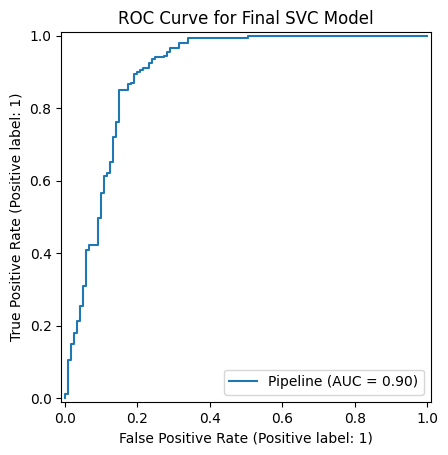

In [64]:
final_scaler = MinMaxScaler()

# Rebuild the best pipeline using the parameters found by Optuna
# Define the best scaler found (StandardScaler)
final_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_columns),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_columns),
    ('num', final_scaler, num_columns)
], remainder='passthrough')

final_model = SVC(
    kernel='linear',
    C=study.best_params['svc_lin_c'],
    probability=True,
    random_state=RANDOM_STATE
)

final_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', final_model)
])

# Train on the full Training Set
final_pipeline.fit(X_train, y_train_encoded)

# Evaluate on the Test Set
y_test_pred_proba_decreased = final_pipeline.predict_proba(X_test)[:, 0]
test_roc_auc = roc_auc_score(1 - y_test_encoded, y_test_pred_proba_decreased)

print(f"Final Test ROC-AUC Score: {test_roc_auc:.4f}")

# Optional: Plot the ROC Curve
RocCurveDisplay.from_estimator(final_pipeline, X_test, y_test_encoded)
plt.title("ROC Curve for Final SVC Model")
plt.show()

Excellent results.

## <a name='Importance'></a> Feature Importance Analysis

Calculating Permutation Importance...


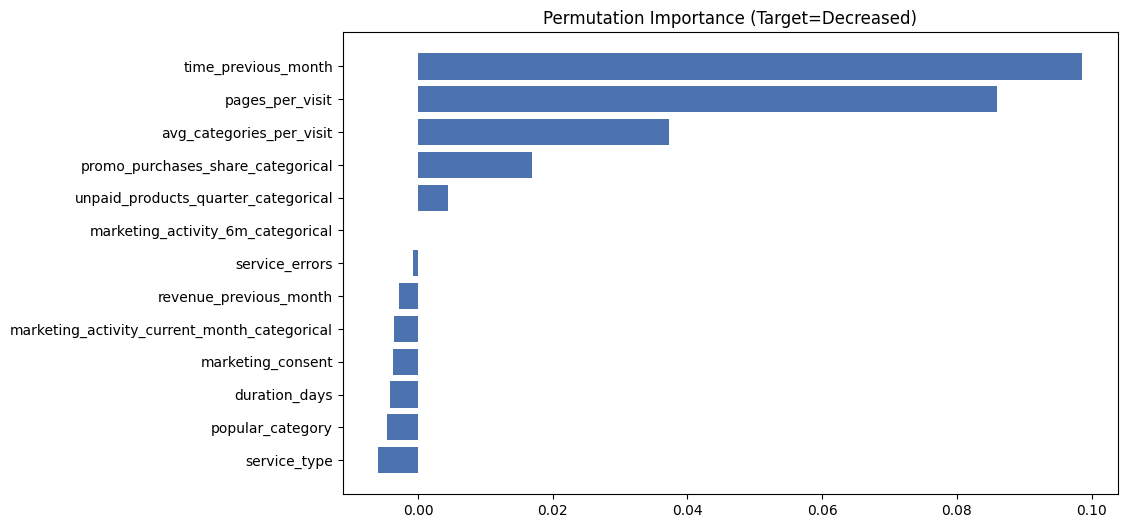

Top 5 Most Important Features:
                                Feature  Importance
12                  time_previous_month    0.098639
6                       pages_per_visit    0.085994
4              avg_categories_per_visit    0.037252
9     promo_purchases_share_categorical    0.016983
10  unpaid_products_quarter_categorical    0.004482


In [65]:
# Access the trained steps from the final pipeline
# We rely on the 'final_pipeline' created and trained in the previous step
preprocessor = final_pipeline.named_steps['preprocessor']
model = final_pipeline.named_steps['model']

# Prepare the data
X_test_preprocessed = preprocessor.transform(X_test)
X_train_preprocessed = preprocessor.transform(X_train)

# Get feature names (these are the original feature names for permutation importance)
original_feature_names = X_test.columns.tolist()

# Define Custom Scorer for Class 0
def custom_auc_class0(y_true, y_pred_proba, **kwargs):

    if y_pred_proba.ndim == 2:
        probs_class_0 = y_pred_proba[:, 0]
    else:
        probs_class_0 = y_pred_proba

    # pos_label=0 ensures we treat the '0' class as the Target
    return roc_auc_score(y_true, probs_class_0) # Note: If your y_true is string, use pos_label argument inside roc_auc_score if needed

custom_scorer = make_scorer(custom_auc_class0, needs_proba=True)

print("Calculating Permutation Importance...")
result = permutation_importance(
    final_pipeline,
    X_test,
    y_test_encoded,
    n_repeats=10,
    random_state=42,
    scoring=custom_scorer,
    n_jobs=-1
)

feature_importance = pd.DataFrame({
    'Feature': original_feature_names,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='#4c72b0')
plt.title('Permutation Importance (Target=Decreased)')
plt.show()

print("Top 5 Most Important Features:")
print(feature_importance.sort_values('Importance', ascending=False).head(5))

Calculating SHAP...


  0%|          | 0/50 [00:00<?, ?it/s]

Plotting SHAP for 'Decreased' (Class 0)...


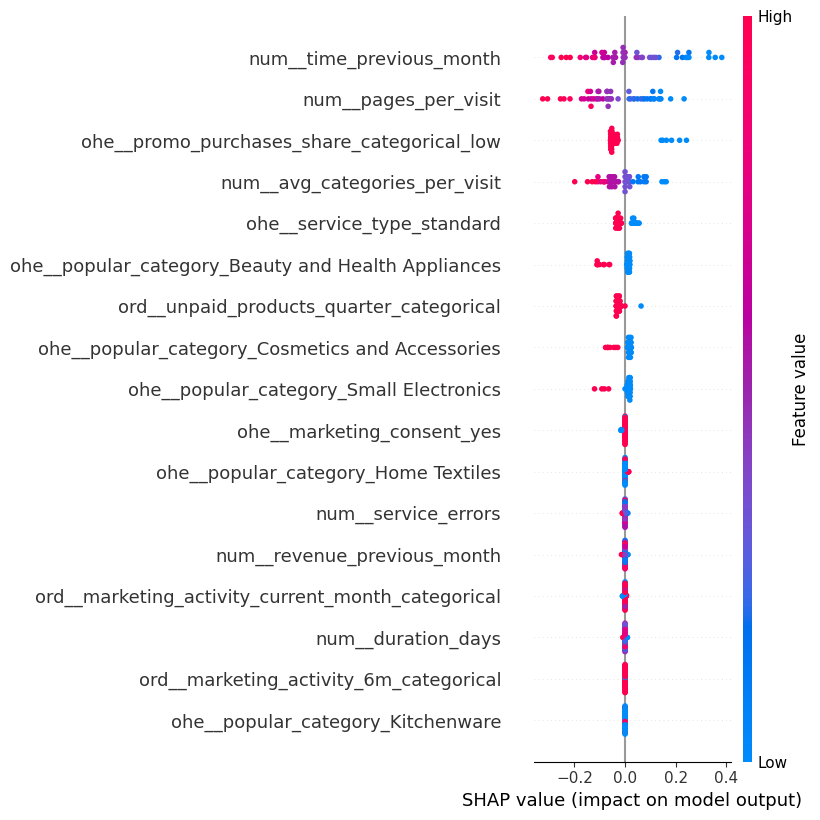

In [67]:
# Create DataFrames with correct column names
# Get feature names after preprocessing from the fitted preprocessor
clean_feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

X_train_shap_df = pd.DataFrame(X_train_preprocessed, columns=clean_feature_names)
X_test_shap_df = pd.DataFrame(X_test_preprocessed, columns=clean_feature_names)

COUNT = 50
X_train_summary = shap.sample(X_train_shap_df, COUNT, random_state=RANDOM_STATE)
X_test_sample = shap.sample(X_test_shap_df, COUNT, random_state=RANDOM_STATE)

print("Calculating SHAP...")
explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)
shap_values = explainer.shap_values(X_test_sample)

# Plot for Class 0 (Decreased)
# shap_values is a 3D array (n_samples, n_features, n_classes)
# To get SHAP values for all samples for Class 0 ('Decreased'), we use shap_values[:, :, 0]
print("Plotting SHAP for 'Decreased' (Class 0)...")
shap.summary_plot(shap_values[:, :, 0], X_test_sample)

**Purchase activity is reduced by (Key Drivers of 'Decreased' Segment):**

* **Low Time Spent (Previous Month):** Users with low engagement time (Blue dots on the right) are the most likely to decrease their purchasing activity.
* **Low Pages per Visit:** High page counts (Red dots) extend to the left (reducing the risk), while fewer pages per visit (Blue dots) drive the prediction toward "Decreased Activity." This suggests shallow engagement is a risk factor.
* **Low Average Categories per Visit:** Similar to page views, users exploring fewer categories (Blue dots on the right) are more likely to drop in activity, whereas high category exploration (Red dots on the left) indicates retention.
* **High Share of Promotional Purchases:** Users predominantly buying on sale (Red dots on the right) are at higher risk of decreasing activity compared to those who buy regardless of discounts.
* **Presence of Unpaid Products:** A high frequency of unpaid products or abandoned carts (Red dots on the right) significantly contributes to the likelihood of decreased purchasing activity.

## <a name='Segmentation'></a> Customer Segmentation

- Let's consider customer segmentation. We'll use modeling results and customer profitability data to perform segmentation.
- We'll select a customer group and propose ways to increase their purchasing activity:
- We'll conduct a graphical and analytical study of the selected customer group.
- We'll make proposals for working with this segment to increase their purchasing activity.

- We'll draw conclusions about the segments:
   - We'll indicate which segment we've selected for further research.
   - We'll describe our proposals and explain why we reached these conclusions.

Let's use the Precision-Recall curve to find the threshold at which precision and recall best meet business goals.

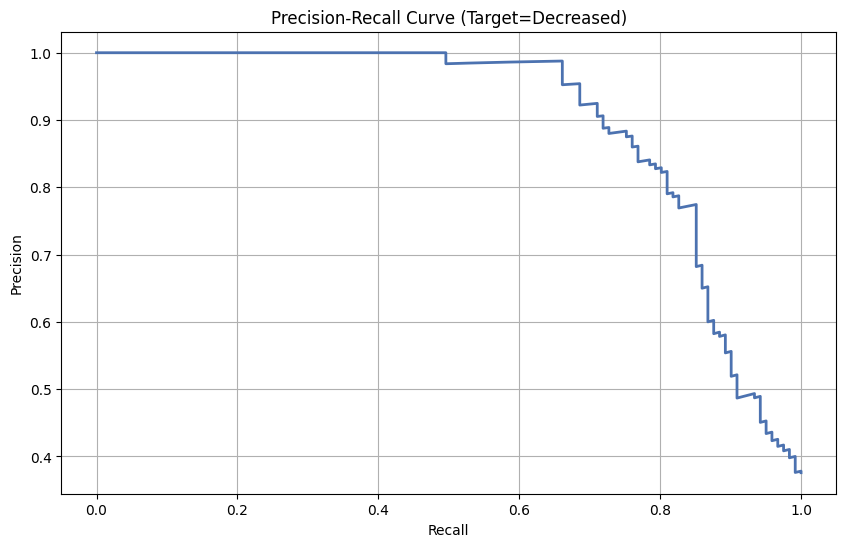

Optimal Threshold (Class 0): 0.4150


In [68]:
# Use precision_recall_curve with an explicit positive class
# Precision-Recall Curve (Explicit pos_label=0)
precision, recall, thresholds = precision_recall_curve(
    y_test_encoded,
    y_test_pred_proba_decreased,
    pos_label=0
)

# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='#4c72b0', lw=2)
plt.title('Precision-Recall Curve (Target=Decreased)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Optimal Threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold (Class 0): {best_threshold:.4f}")

We have identified an optimal threshold of 0.41, which prioritizes customer retention.

It is necessary to identify those buyers for whom the model predicted a high probability of a decrease in activity

In [69]:
# Get Predictions for the FULL Dataset
predictions = final_pipeline.predict_proba(X)[:, 0]

# Apply Threshold
prediction_flags = predictions > best_threshold
df_decline = df_full.loc[prediction_flags].copy()

# Print Statistics
print(f"Total Customers: {len(df_full)}")
print(f"Segment Size (At Risk): {len(df_decline)}")
print(f"Percentage: {len(df_decline) / len(df_full):.1%}")
print("\nSegment Info:")
df_decline.info()

Total Customers: 1285
Segment Size (At Risk): 476
Percentage: 37.0%

Segment Info:
<class 'pandas.core.frame.DataFrame'>
Index: 476 entries, 215349 to 216645
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   buyer_activity                                476 non-null    object 
 1   service_type                                  476 non-null    object 
 2   marketing_consent                             476 non-null    object 
 3   duration_days                                 476 non-null    int64  
 4   popular_category                              476 non-null    object 
 5   avg_categories_per_visit                      476 non-null    int64  
 6   service_errors                                476 non-null    int64  
 7   pages_per_visit                               476 non-null    int64  
 8   marketing_activity_6m_categorical             476 non-

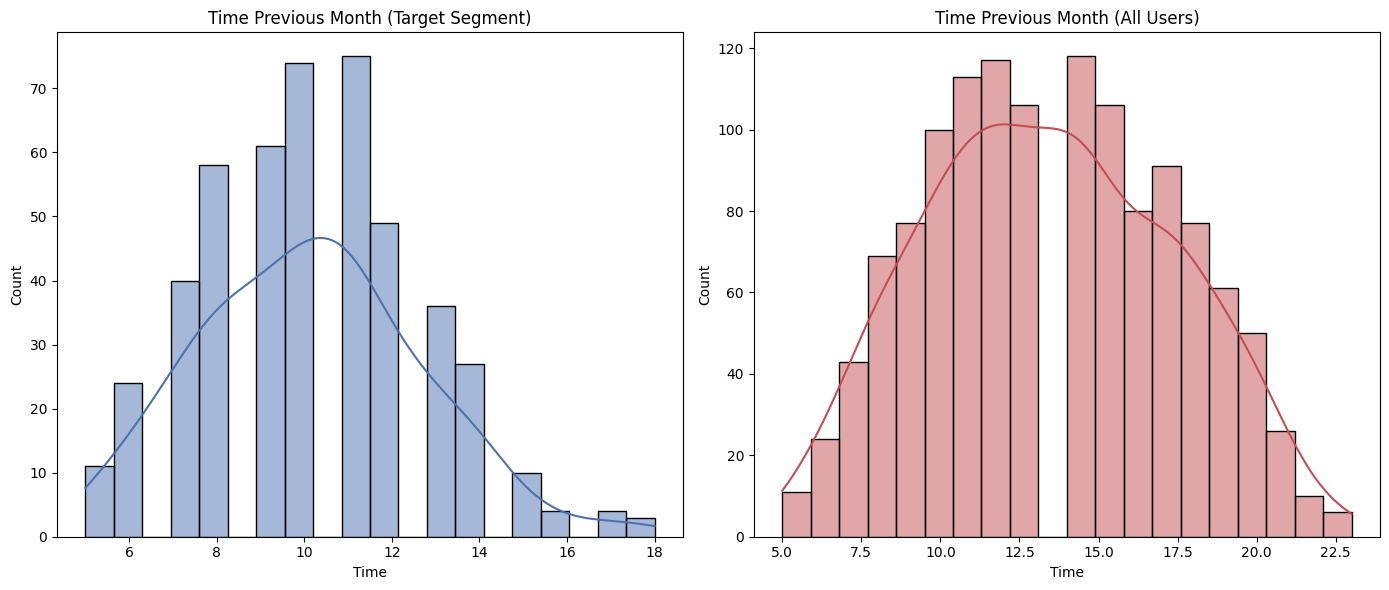

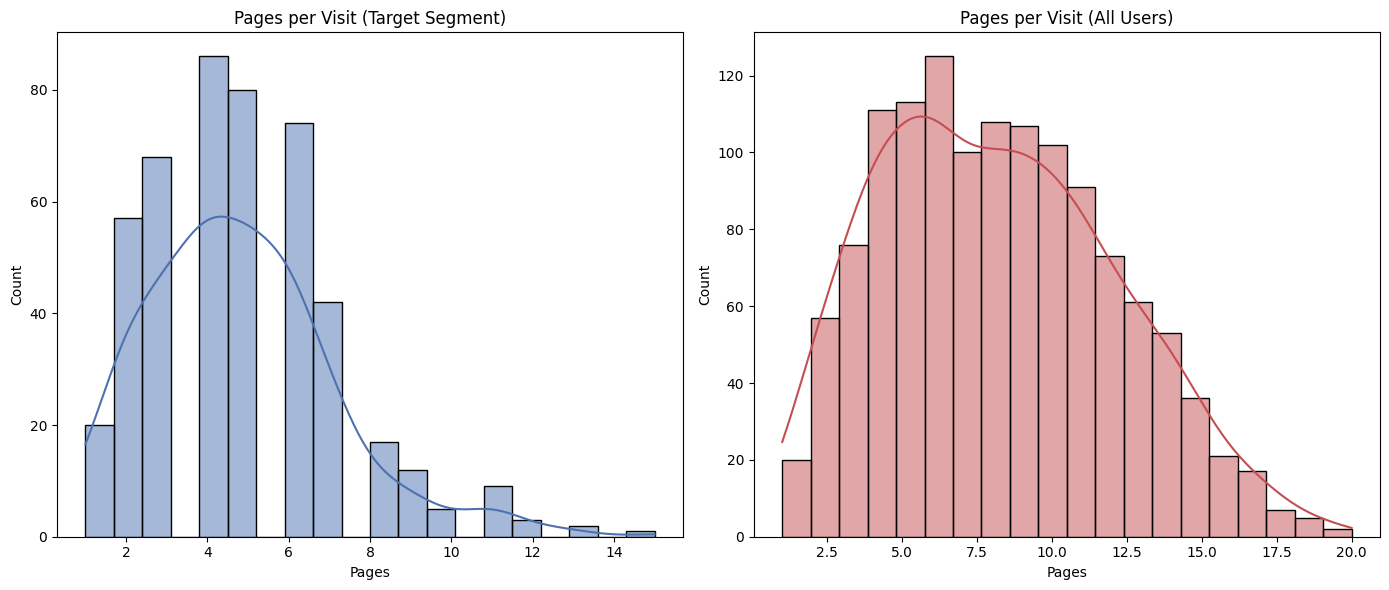

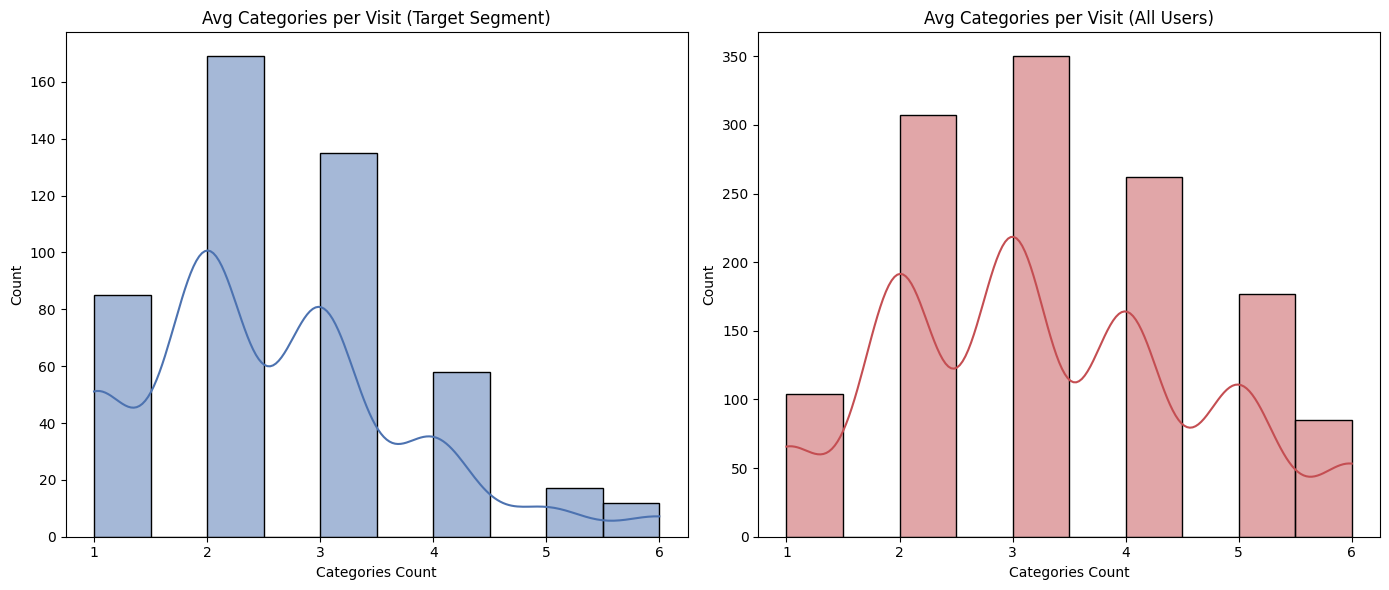

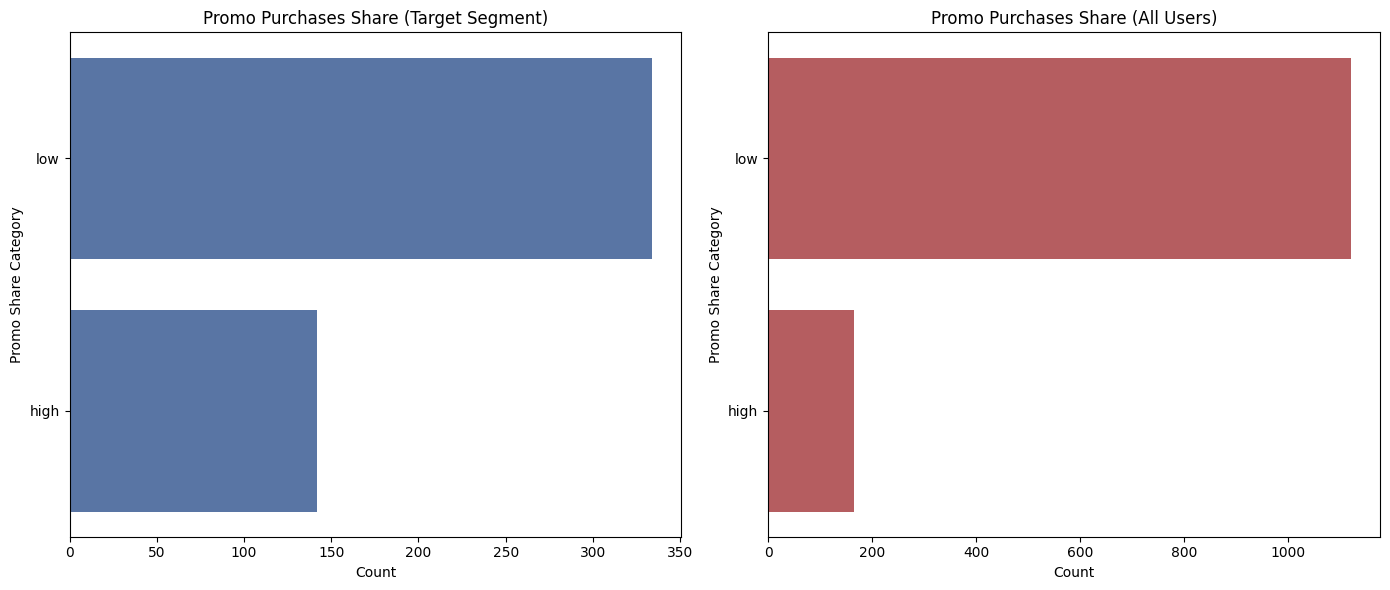

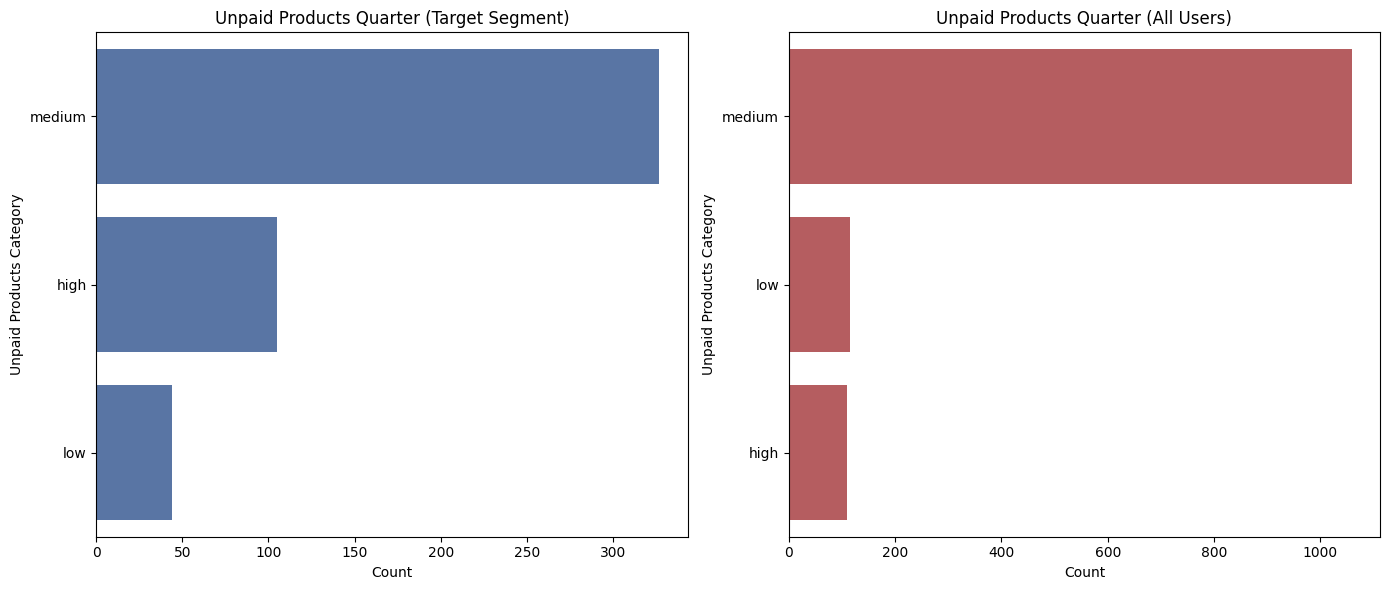

In [70]:
# Visualization: Segment vs All Users
# We compare the behavior of the 'At Risk' segment (Blue) against the Average User (Red)

# Top Feature 1: Time Spent (Previous Month) ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_decline['time_previous_month'], bins=20, color='#4c72b0', kde=True)
plt.title('Time Previous Month (Target Segment)')
plt.xlabel('Time')

plt.subplot(1, 2, 2)
sns.histplot(df_full['time_previous_month'], bins=20, color='#c44e52', kde=True)
plt.title('Time Previous Month (All Users)')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

# Top Feature 2: Pages per Visit ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_decline['pages_per_visit'], bins=20, color='#4c72b0', kde=True)
plt.title('Pages per Visit (Target Segment)')
plt.xlabel('Pages')

plt.subplot(1, 2, 2)
sns.histplot(df_full['pages_per_visit'], bins=20, color='#c44e52', kde=True)
plt.title('Pages per Visit (All Users)')
plt.xlabel('Pages')
plt.tight_layout()
plt.show()

# Top Feature 3: Average Categories per Visit ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_decline['avg_categories_per_visit'], bins=10, color='#4c72b0', kde=True)
plt.title('Avg Categories per Visit (Target Segment)')
plt.xlabel('Categories Count')

plt.subplot(1, 2, 2)
sns.histplot(df_full['avg_categories_per_visit'], bins=10, color='#c44e52', kde=True)
plt.title('Avg Categories per Visit (All Users)')
plt.xlabel('Categories Count')
plt.tight_layout()
plt.show()

# Top Feature 4: Promo Purchases Share (Categorical) ---
# This feature is categorical, so we use countplot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
# Ensure categories are ordered by frequency in the segment for clarity
order_decline = df_decline['promo_purchases_share_categorical'].value_counts().index
sns.countplot(y='promo_purchases_share_categorical', data=df_decline, order=order_decline, color='#4c72b0')
plt.title('Promo Purchases Share (Target Segment)')
plt.xlabel('Count')
plt.ylabel('Promo Share Category')

plt.subplot(1, 2, 2)
# Ensure categories are ordered by frequency in the full set for comparison
order_full = df_full['promo_purchases_share_categorical'].value_counts().index
sns.countplot(y='promo_purchases_share_categorical', data=df_full, order=order_full, color='#c44e52')
plt.title('Promo Purchases Share (All Users)')
plt.xlabel('Count')
plt.ylabel('Promo Share Category')
plt.tight_layout()
plt.show()

# Top Feature 5: Unpaid Products Quarter (Categorical) ---
# This feature is categorical, so we use countplot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
order_decline_unpaid = df_decline['unpaid_products_quarter_categorical'].value_counts().index
sns.countplot(y='unpaid_products_quarter_categorical', data=df_decline, order=order_decline_unpaid, color='#4c72b0')
plt.title('Unpaid Products Quarter (Target Segment)')
plt.xlabel('Count')
plt.ylabel('Unpaid Products Category')

plt.subplot(1, 2, 2)
order_full_unpaid = df_full['unpaid_products_quarter_categorical'].value_counts().index
sns.countplot(y='unpaid_products_quarter_categorical', data=df_full, order=order_full_unpaid, color='#c44e52')
plt.title('Unpaid Products Quarter (All Users)')
plt.xlabel('Count')
plt.ylabel('Unpaid Products Category')
plt.tight_layout()
plt.show()

**According to the graph:**

- `Time_previous_month`: We see a more right-skewed distribution for segmented users, peaking at 10, while the remaining users have a more bimodal distribution, split between those who spent more time on the site (peaking at 11) and less time (peaking at 15). This may also indicate that this group is dominated by users who are less engaged with the site and their activity has decreased compared to the others.
- `Pages_per_visit`: Both groups have a right-skewed distribution, but the segmented group is more skewed to the left compared to the overall group. This may well indicate low engagement and potentially decreased activity among segmented users.
- `Average_category_views_per_visit`: The segmented group has a right-skewed distribution, while the remaining group has a more normal distribution with a slight left shift.
- `Promotional_Purchases_Category`: Segmented users make more promotional purchases, while other users make fewer promotional purchases.
- `unpaid_products_quarter_categorical`: Segmented users have more unpaid items in their cart, while other users have fewer.

**Segmented Customers Profile (At Risk)**

- `Time Spent (Previous Month)`: Most users predicted to decrease activity spent an average of 11 minutes on the site.

- `Average Categories per Visit`: Most users predicted to decrease activity view only 2–3 categories on average per visit.

- `Pages per Visit`: There is a high peak around 4 pages view; most users predicted to decrease activity view an average of 4 pages per visit.

- `Unpaid Products (Quarterly)`: Users predicted to decrease activity tend to have a higher number of unpaid products in their cart compared to other users.

- `Promotional Purchases`: Users predicted to decrease activity prefer purchasing items on promotion (sale).

## <a name='Conclusion'></a> General Conclusion

**Project Goal:** The "One Click" company sought to address the issue of declining purchasing activity among its loyal customers. The primary objective was to develop a machine learning model capable of predicting the likelihood of decreased activity and to identify specific customer segments. This enables the creation of personalized offers aimed at boosting engagement and retention.

**Data Source and Preprocessing**: Data was aggregated from multiple sources: market_file.csv, market_money.csv, and market_time.csv. Comprehensive preprocessing was performed prior to modeling:

**Data Integrity**: Confirmed no initial missing values; data types were verified against info().

**Feature Engineering**: Features such as `marketing_activity_6m`, `marketing_activity_current_month`, `promo_purchases_share`, and `unpaid_products_quarter` were converted to categorical variables due to skewed distributions.

**Outlier Removal**: Anomalies were detected and removed, specifically in the Revenue parameters.

**Merging**: The three source tables were merged into a single dataset. Post-merge analysis revealed missing values and duplicates, which were subsequently removed.

**Multicollinearity**: A correlation matrix analysis revealed strong multicollinearity. To eliminate data leakage and redundancy, revenue_pre_previous_month, revenue_current_month, and time_current_month were dropped. For remaining features with moderate correlation, we relied on the regularization inherent in the models.

**Modeling Strategy**: We utilized a Pipeline to evaluate four distinct classifiers:

- DecisionTreeClassifier
- KNeighborsClassifier
- LogisticRegression
- SVC (Support Vector Classifier)

**Hyperparameter Tuning**: We employed `Optuna` for automated hyperparameter optimization. Within the Optuna trials, we used Cross-Validation and optimized for the `ROC AUC` metric to effectively handle the class imbalance.

**Best Model**: The `SVC (Linear Kernel)` proved to be the best-performing model using the parameters found by Optuna and the MinMaxScaler. It achieved excellent results:
- ROC AUC (Cross-Validation): 0.89
- ROC AUC (Test Set): ~0.90

**Feature Importance Analysis**: To improve model interpretability, we analyzed Permutation Importance, identifying the top 5 key drivers of the prediction:
- time_previous_month
- pages_per_visit
- avg_categories_per_visit
- promo_purchases_share_categorical
- unpaid_products_quarter_categorical

**SHAP Analysis Conclusions**: Based on the SHAP summary plot (targeting Class 0: 'Decreased Activity'), the following factors were identified as drivers for reducing purchasing activity:
- **Low Engagement Time**: Users who spent very little time on the site in the previous month are highly likely to decrease activity.
- **Shallow Navigation**: Users viewing very few pages per visit and exploring a low number of categories are at high risk.
- **Reliance on Promotions**: Users with a high share of promotional purchases  are more likely to churn or decrease activity compared to full-price buyers.
- **Abandoned Carts**: A high number of unpaid products in the quarter (Red dots) is a strong signal of impending decreased activity.

**Customer Segmentation** (The "At Risk" Segment): We identified a specific segment of customers predicted to decrease activity, comprising 37% of the total customer base (476 users). Their profile includes:
- **Short Visits**: They spend an average of only 11 minutes on the site.
- **Low Interaction**: They typically view only 4 page and 1-3 categories per visit.
- **Unpaid Items**: They have a significantly higher rate of unpaid products (abandoned carts) compared to stable users.
- **Promo-Focused**: They primarily engage with discounted items.

**Business Recommendations:**
- Re-engagement Strategy: Since low time-on-site and low page views are major risk factors, implement gamification or "content discovery" features to encourage longer browsing sessions.
- Abandoned Cart Recovery: Given the high importance of unpaid_products_quarter, implement aggressive push notifications or email reminders for users with unpaid items to convert them into purchases.
- Shift from Promo-Dependency: For the segment heavily relying on promotions, offer personalized "bundle" deals that include non-promo items to gradually shift their behavior toward full-price purchases.
- Personalized UI: For users viewing only 1 category, personalize the homepage to showcase a wider variety of relevant categories immediately upon login to broaden their interest.